In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import seaborn as sns
import os
import time
import random
from utils.metrics import *

In [2]:
randdata=[42, 168, 573, 81, 1094 , 9,
 23, 1387, 937 ,1]  #  np.random.random_sample(10)
#print(randdata)

In [3]:
# setting random seed
SEED=randdata[0]   #  42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
dicdata='../../venv/Datasets/'
dicnpy='../../venv/dataUNSW/'
dicoutcome='../../venv/MyBayesian/unsw_checkpoints/'
#dicoutcome1='../../venv/MyBayesian/unsw_checkpoints/MultiNormal/'

In [5]:
def column_split_bina(ds):
    '''split dataset to data_x,data_y for binary classification '''
    if type(ds)==pd.DataFrame:
        data_x=np.asarray(ds.iloc[:,:-2]).astype(np.float32)
        data_y=np.asarray(ds.iloc[:,-1]).astype(np.float32)
    elif type(ds)==np.ndarray:
        data_x=ds[:,:-2].astype(np.float32)
        data_y=ds[:,-1].astype(np.float32)        
    else:
        data_x=False
        data_y=False
    return data_x, data_y

In [6]:
# Get the training data
try:
    normal_train=np.load(dicnpy+'Normal_train_80_2.npy',allow_pickle=True)
    normal_test=np.load(dicnpy+'Normal_test_20_2.npy',allow_pickle=True)
except IOError:
    print("Normal.npy didn't exist!")
    
normal_train_x, _ =column_split_bina(normal_train)
original_dim = normal_train_x.shape[1]
input_shape = (original_dim,)

klw=normal_train_x.shape[0]
#intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

# build model

# VI

In [13]:

def make_n_prior(shape, dtype=np.float32,independent=False):
    if independent:
        return   tfd.Independent(tfd.Normal(loc=tf.zeros(shape), scale=1),  reinterpreted_batch_ndims=1)
    else:
        return tfd.Normal(loc=tf.zeros(shape), scale=1)   # scale=0.01 ?
    
tfb = tfp.bijectors

def make_mvn_prior(ndim, trainable=False, offdiag=False):
        if not trainable:
            if offdiag:
                # With covariances
                # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.zeros(ndim),
                    scale_tril=tf.eye(ndim)
                )
            else:            
                if True:  # kl_exact needs same dist types for prior and latent.
                    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
                else:
                    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                            reinterpreted_batch_ndims=1)
        else:
            # Note, in TransformedVariable, the initial value should be that AFTER transform; weight trainable.
            if offdiag:
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_tril=tfp.util.TransformedVariable(
                        tf.random.normal([ndim, ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        tfb.FillScaleTriL(), name="prior_scale")
                )
            else:
                scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
                prior = tfd.MultivariateNormalDiag(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_diag=tfp.util.TransformedVariable(
                        tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)]),
                        name="prior_scale"
                    )
                )                
        return prior

In [8]:
#reg_L2=     1e-5    #  0.01 #

In [15]:
#from tensorflow.keras.initializers import RandomNormal, Constant
#2layers (512,256,64)
# 2 layers (128,64,32)
#prior =tfd.Independent(tfd.Normal(loc=tf.zeros(64), scale=1)    , reinterpreted_batch_ndims=1)

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(128,               
         activation='relu'), #tfkl.LeakyReLU(alpha=0.3)) 

    tfkl.Dense(64, 
                            #activity_regularizer=tfk.regularizers.L2(0.01), 
                              activation='relu'), #tfkl.LeakyReLU(alpha=0.3))
    
#     tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
#                                 beta_initializer=tf.random_normal_initializer(mean=0, stddev=0.05),   #RandomNormal(mean=0.0, stddev=0.05), 
#                                #     gamma_initializer=Constant(value=0.9)
#                                 ),
#     #tfkl.LayerNormalization()   
    
    tfkl.Dense( 32,  
               activation='relu'),
###  latent
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 32, activity_regularizer=tfpl.KLDivergenceRegularizer(make_mvn_prior(32,offdiag=True) ,use_exact_kl=False, weight=1.0)) 
  
])

'''
    #VAE
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 32, activity_regularizer=tfpl.KLDivergenceRegularizer(prior,use_exact_kl=False, weight=1.0))  # 
             #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)  
             
 #### for latent
tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
        # kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  tfk.initializers.he_normal(),  
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 32), 
  
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                       scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
                       
 tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))
                   
    '''
#encoder =tfk. Model(inputs, [z,z_mean,z_log_var], name='encoder')
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               6144      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 560)               18480     
                                                                 
 multivariate_normal_tri_l_1  ((None, 32),             0         
  (MultivariateNormalTriL)    (None, 32))                        
                                                                 
Total params: 34,960
Trainable params: 34,960
Non-trainable params: 0
__________________________________________________

In [16]:
# option 2, decoder model using Model API
latent_inputs =tfk. Input(shape=(32,), name='z_sampling')
x = tfkl.Dense(64,
               activation='relu')(latent_inputs)

x = tfkl. Dense(128, 
                activation='relu')(x)

outputs=tfkl.Dense(original_dim,
                    activation='sigmoid')(x)
'''
#### for latent
x=tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(original_dim),              
        # kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  tfk.initializers.he_normal(),  
        bias_initializer=tf.zeros_initializer() )(x)
outputs=tfpl.MultivariateNormalTriL( original_dim)(x)
  
outputs=  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                       scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))) (x)
                       
outputs= tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) )) (x)
'''
# sampling from outputs?
#outputs = Lambda(sample,output_shape=(original_dim,),name='decoder_output')([z_post_mu,z_post_std])

# z_post_std=tf.math.exp(z_post_log_var) # using when activation not 'sigmoid'
# outputs=tf.add(z_post_mu, z_post_std * tf.random.normal(shape=(original_dim,)))  

#outputs=tf.add(z_post_mu, z_post_log_var * tf.random.normal(shape=(original_dim,)))
# outputs= Dense(original_dim, activation='sigmoid')(x)

# Instantiate the decoder model:
#decoder=tfk.Model(latent_inputs,[z_post_mu, z_post_log_var,x_recons], name='decoder')
#decoder = Model(latent_inputs, [z_post_mu, z_post_std, outputs], name='decoder')
decoder=tfk.Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 47)                6063      
                                                                 
Total params: 16,495
Trainable params: 16,495
Non-trainable params: 0
_________________________________________________________________


In [17]:
 
loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        #z_sample, mu, sd = self.encoder(x_input)
        z_sample=self.encoder(x_input)        
        #post_mu, post_std ,x_recons= self.decoder(z_sample  )#  .sample())           
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
        
        x_recons=self. decoder(z_sample   )#.sample() )
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
        
        '''
        kl_divergence = - 0.5 * tf.math.reduce_sum(1+tf.math.log(tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1)
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        '''
        #return post_mu, post_std ,x_recons
        return x_recons
    
    #@tf.function

    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            #z_sample, mu, sd = self.encoder(x_true)
            z_sample=self.encoder(x_true)
            # post_mu, post_std ,x_recons= decoder(z_sample  )# .sample())
            # post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            x_recons=self. decoder(z_sample  )#.sample())
            #post_mu, post_std ,x_recons= self.decoder(z_sample )#.sample())
            #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            
            # calculating KL for isotic multivariate Gaussian distribtuion
            #kl_loss = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)+1e-10) -tf.math.square(mu) - tf.math.square(sd),axis=1)  # shape=(batch_size, )
            
            # 2.MVN
            #dist=tfp.distributions.MultivariateNormalDiag(post_mu,post_std)   #concerned Diag deviation; but deprecated; same value to log_prob()
            # 3. MVN Tril
            #scale=tf.matmul(post_std,post_std,transpose_a=True)  # Multivariate Gaussian full covariance 
            #dist=tfd.MultivariateNormalTriL(post_mu,scale)     
            
            # # 1.Gaussian
            # dist= tfp.distributions.Normal(post_mu,post_std) 
            # reconstruction_loss =-dist.log_prob(x_true) #
            #reconstruction_loss= -tf.reduce_mean(tf.math.exp(dist.log_prob(x_true)) )
            
            #reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            #reconstruction_loss =tfk.losses.MeanSquaredError()(x_true,x_recons) # tf.reduce_sum(tf.reduce_square(x_true - x_recons))       #MSE
         
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

## Model

In [8]:
# option 2, decoder model using Model API
latent_inputs =tfk. Input(shape=(8,), name='z_sampling')
x = tfkl.Dense(16,  # 256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tfk.initializers.he_normal(), # tf.zeros_initializer() ,        
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),     
               bias_regularizer=tfk.regularizers.L2(reg_L2),
               activation='relu')(latent_inputs)
x=tfkl.Dropout(dropout_rate)(x,training=True)

x = tfkl. Dense(32, # 512, 
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),  
                bias_regularizer=tfk.regularizers.L2(reg_L2),
                activation='relu')(x)

x=tfkl.Dropout(dropout_rate)(x   ,training=True)
#x_recons=tfkl.Dense(original_dim,

x =tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))(x)
x_recons=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),   
                    bias_regularizer=tfk.regularizers.L2(reg_L2),
                    activation='sigmoid')(x)


# x = tfkl. Dense(original_dim, 
#         kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
#         bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
#                            kernel_regularizer=tfk.regularizers.L2(reg_L2),  
#                 bias_regularizer=tfk.regularizers.L2(reg_L2),
#                 activation='relu')(x)

'''

 ###### from latent  ; adding dsitrubiton layer;   should use RP estimate, now hasn't evident； 
 
x = tfkl. Dense(original_dim, 
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),  
                bias_regularizer=tfk.regularizers.L2(reg_L2),
                activation='relu')(x)
x_recons =tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))(x)
                                 
x_recons=tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t, 
                          scale=1e-3 + tf.math.softplus(0.01 * t)))(x)

x=tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(original_dim),              
        kernel_initializer=tfk.initializers.he_normal(),  # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() )(x)
x_recons=    tfpl.MultivariateNormalTriL( original_dim)(x)
'''
# Instantiate the decoder model:
#decoder=tfk.Model(latent_inputs,[z_post_mu, z_post_log_var,x_recons], name='decoder')
#decoder=tfk.Model(latent_inputs, outputs, name='decoder')

# outputs here is for last layer alea noise; z_post_mu,z_post_std for reconstruction RP
#decoder =tfk. Model(latent_inputs, [z_post_mu, z_post_std, outputs], name='decoder')  
decoder=tfk.Model(latent_inputs, x_recons, name='decoder')  # for reconstruction error, mae,mse
decoder.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 distribution_lambda (Distri  ((None, 32),             0         
 

2023-08-08 08:54:29.706995: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## model class

In [10]:
 
#loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        #z_sample, mu, sd = self.encoder(x_input)
        z_sample=self.encoder(x_input)        
        x_recons=self.decoder(z_sample  )#.sample() )
        #post_mu, post_std ,x_recons=self. decoder(z_sample)  
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
        '''
        kl_divergence = - 0.5 * tf.math.reduce_sum(1+tf.math.log(tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1)
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        '''
        return     x_recons    
        #return  post_mu, post_std , x_recons
    
    #@tf.function

    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:            
            #x_true=x_true+0.01   # homogeneous noise, 
            
            #z_sample, mu, sd = self.encoder(x_true)
            z_sample=self.encoder(x_true)
            
            x_recons=self.decoder(z_sample   )#.sample()   )
            #post_mu, post_std ,x_recons=self. decoder(z_sample)
            #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            
            # calculating KL for isotic multivariate Gaussian distribtuion
            #kl_loss = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)+1e-10) -tf.math.square(mu) - tf.math.square(sd),axis=1)  # shape=(batch_size, )
            
            # 2.MVN
            #dist=tfp.distributions.MultivariateNormalDiag(post_mu,post_std)   #concerned Diag deviation; but deprecated; same value to log_prob()
            # 3. MVN Tril
            #scale=tf.matmul(post_std,post_std,transpose_a=True)  # Multivariate Gaussian full covariance 
            #dist=tfd.MultivariateNormalTriL(post_mu,scale)     
            #dist=x_recons
            # 1.Gaussian
            # dist= tfp.distributions.Normal(post_mu,post_std) 
            #reconstruction_loss =-dist.log_prob(x_true) #
            #reconstruction_loss= -tf.reduce_mean(tf.math.exp(dist.log_prob(x_true)) )
            
            #reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons)  ) # crossentropy
            reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            #reconstruction_loss =tfk.losses.MeanSquaredError()(x_true,x_recons) # tf.reduce_sum(tf.reduce_square(x_true - x_recons))       #MSE
            '''
            loss_para=0.0
            # KL_loss_para
            for i in range(0,len(self.layers)):
                layer_weight=self.layers[i].weights #.get_weights()
                if len(layer_weight)==2:
                    wei=layer_weight[0]
                    bia=layer_weight[1]
                    
                    # dist_para~ Gaussian
                    prior_para=tfd.Normal(loc=np.zeros(wei.shape), scale=1)    #tfd.Independent(, reinterpreted_batch_ndims=1)                    
                    
                    # 1. KL Gaussian(wei,bia)
                    loss_para= loss_para+ tfd.Normal(loc=wei, scale=bia).kl_divergence(prior_para) 
                    
                    # 3.dist_para~ Multivariat Gaussian Diag
                    prior_para=tfd.MultivariateNormalDiag(loc=np.zeros(wei.shape), scale=1)    #tfd.Independent(, reinterpreted_batch_ndims=1) 
                    loss_para= loss_para+ tfd.MultivariateNormalDiag(loc=wei, scale=bia).kl_divergence(prior_para)
                    
                    
                    #2.1 log_prob()  wei~ Gaussian ; bia ~ Gaussian
                    loss_para = loss_para+prior_para.log_prob(wei) 
                    loss_para = loss_para +prior_para.log_prob(bia)
                    loss_para=-loss_para
                    
                    # 2.2 KL
                    loss_para = loss_para+ tfd.Normal(loc=wei, scale=np.var(wei)).kl_divergence(prior_para) 
                    loss_para = loss_para+ tfd.Normal(loc=bia, scale=np.var(bia)).kl_divergence(prior_para)                    
                    
            loss_para=loss_para/len(self.layers)
            '''   
            '''
            # uncertainty  @Kwon
            al = tf.math.reduce_mean(x_recons*(1-x_recons), axis=1)
            ep = tf.math.reduce_mean(x_recons**2, axis=1) - tf.math.reduce_mean(x_recons, axis=1)**2 
            
            # @ UQ_ale_epi_Kendall(post_mu,post_std)
            al = np.mean(post_std**2, axis=1)
            ep = np.mean(post_mu**2, axis=1) - np.mean(post_mu, axis=1)**2
            
            t_uncer=al+ep
            '''
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

# Training model

In [8]:
# M=5   # the true M=1 when minibatch big enough,>100
#savegroup=''#"unsw-1-drop-latent-Tril-bce-"
savename="unsw-4-VAE-seed0-mae"

In [9]:
# scale data
t = MinMaxScaler()
t.fit(normal_train_x)
normal_train_x = t.transform(normal_train_x)

In [18]:
# option2, correct in theory. (Kwon's  UQ paper)
# T samples from one training phase

# compile and train tfk.Model
BDL_model = BAE_AD(orig_dim=original_dim)
BDL_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08,amsgrad=True))#decay=1.0/200,  # not good of Adam and decay
#vae_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0.3, decay=0.01, nesterov=True))

batchsize=512
epochsize=100
start=time.time()
train_history= BDL_model.fit(normal_train_x, batch_size=batchsize,epochs=epochsize,shuffle=True)# sever will restart when epoches=200
                        #verbose=1,metrics=[tf.keras.metrics.KLDivergence()]) #['accuracy'])
end=time.time()
print(f"\nTime to training: {round(end-start,5)} seconds.")

runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['train'],'M':[1],'DistNum':[0],'time':[round(end-start,5)],'batch':[batchsize],'epoch':[epochsize]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

Epoch 1/100
3467/3467 [==============================] - 19s 5ms/step - loss: 0.1224 - reconstruction_loss: 0.0695
Epoch 2/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0368 - reconstruction_loss: 0.0351
Epoch 3/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0318 - reconstruction_loss: 0.0312
Epoch 4/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0304 - reconstruction_loss: 0.0302
Epoch 5/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0296 - reconstruction_loss: 0.0294
Epoch 6/100
3467/3467 [==============================] - 18s 5ms/step - loss: 0.0292 - reconstruction_loss: 0.0291
Epoch 7/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0290 - reconstruction_loss: 0.0289
Epoch 8/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0287 - reconstruction_loss: 0.0286
Epoch 9/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.

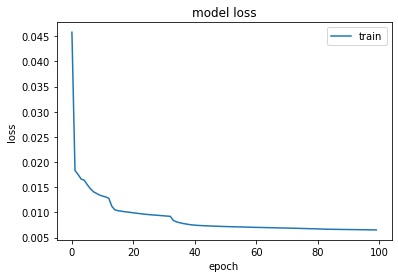

In [11]:

pyplot.plot(train_history.history['loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right');
pyplot.show()

# save or load model

In [19]:
#BDL_model.save('./myModels/unsw_normal')

# # Save the weights
BDL_model.save_weights('./unsw_checkpoints/'+savename)

# save the model
#BDL_model.save('./unsw_checkpoints/111+'+savename)

#test_model=tf.keras.saving.load_model('./unsw_checkpoints/111+'+savename+'.keras')

In [18]:
#reconstructed_model = tfk.models.load_model("./myModels/unsw_normal_")
BDL_model = BAE_AD(orig_dim=original_dim)
#oldsavename='unsw-1-drop-input-mae' # None  # the old file name 
## Restore the weights
BDL_model.load_weights('./unsw_checkpoints/'+savename)# oldsavename)  #, by_name=True)  #when using for transforming
#savename='unsw-11-drop-input-mae'#'unsw-33-drop-input-bce' # the future name
## Evaluate the model
#loss, acc = BDL_model.evaluate(normal_train_x)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# function set

In [20]:
attack_types=['Normal','Shellcode','Exploits','Fuzzers','Reconnaissance','Generic','Worms','Analysis','DoS','Backdoors','AllAttacks']

In [23]:
''' 
return RP(reconstruction probabilities), p(x|x`),p(x|mu,sigma**2)
 X: inputs
 mu,sigma from the outputs, from the last hidden layer of decoder? ,,,,or as means of each mu,sigma of hidden layers of decoder.
 RP could be used in training phase or testing phase.
'''

# only for multivariate Gaussian including MultivariateNoramlDiag() and MultivariateNormalTril()

#from scipy.stats import multivariate_normal
def RP_multivariate(x_orig,mu_post, sigma_post, L=1):
    '''
    args: 
    mu_post, sigma_post: come from the final decoder layer of test model or train model.
    x_orig: the inputs of test model or train model.
    L: the number of latent layers
    return:
    the probabilities of the distribution of x_orig on (mu_post,sigma_post) using multivariate Gaussian distribution.
    Another alternative method is original multivariate distribution model or mixture.
    '''
    #sigma_post2=tf.clip_by_value(sigma_post,1e-10, tf.reduce_max(sigma_post))
    ##sigma_post2==tf.math.exp(sigma_post2)
   
    recon_dist =tfp.distributions.MultivariateNormalDiag(mu_post,sigma_post)  # Multivariate Gaussian
    
    #scale=tf.matmul(sigma_post,sigma_post,transpose_a=True)  # Multivariate Gaussian full covariance 
    ##scale = tf.linalg.cholesky(sigma_post2)
    #recon_dist=tfd.MultivariateNormalTriL(mu_post,scale)
    reconstructed_prob=recon_dist.log_prob(x_orig)
    
    # scale data
    t = MinMaxScaler()
    reconstructed_prob=tf.reshape(reconstructed_prob,[-1,1])
    t.fit(reconstructed_prob)
    reconstructed_prob = t.transform(reconstructed_prob)
      
    return reconstructed_prob

def RP_normal_outp(x_orig,x_recons,L=1):
    '''    only for Normal distribution'''
    mu=tf.math.reduce_mean (x_recons,axis=1,keepdims=True)
    sigma=tf.clip_by_value( tf.math.reduce_std(x_recons, axis=1,keepdims=True), 1e-10, tf.reduce_max(x_recons))
    recon_dist =tfp.distributions.Normal(mu,sigma) 
    
    p=recon_dist.prob(x_orig)
    p1=tf.math.reduce_mean(p,axis=-1)  
    return p1

def RP_normal(x_orig,mu,sigma,L=1):
    '''     only for Normal distribution'''
    recon_dist =tfp.distributions.Normal(mu,sigma) 
    
    p=recon_dist.prob(x_orig)
    p1=tf.math.reduce_mean(p,axis=-1)  
    return p1

In [21]:

def metric3UQ(fileforname, skiprow=None):
    pd_reader=pd.read_csv('../../venv/MyBayesian/pplots/BDL'+fileforname+'+allmetrics.csv'   ,skiprows=skiprow)   
    #print(pd_reader.head())
    save_path="pplots/BDL"+fileforname+'+allmetricsSum'+".csv"
    
    modelname='BDL'
    model_dict_total={}
    model_dict_alea={}
    model_dict_epis={}
    model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
    for each in range(1,len( attack_types)):
        fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
        fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')

        for i in range(1,len(pd_reader),18*3):
            if '+' in pd_reader.iloc[i,0] :

                if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                    legendd=pd_reader.iloc[i,0].split('+')[0]

                    if legendd in model_dict_total.keys():
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                        model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                        model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)

                    else: 
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                        model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                        model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16)  

                    #fig_title=pd_reader.iloc[i,0]
                    try:
                        xx=pd_reader.iloc[i+2,1:].astype(int)
                    except:
                        print(i)

                    # total uncertainty
                    y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                    y_uncer2=pd_reader.iloc[i+15+18,1:].astype(np.float16)  # alea
                    y_uncer3=pd_reader.iloc[i+15+18*2,1:].astype(np.float16)   #epis
                    #plot_title=pd_reader.iloc[i+2,0]            
                    #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # auc
                    y_values=pd_reader.iloc[i+9,1:].astype(np.float16)   # accu_total
                    y_values2=pd_reader.iloc[i+9+18,1:].astype(np.float16)   # accu_alea
                    y_values3=pd_reader.iloc[i+9+18*2,1:].astype(np.float16)   # accu_epis

                    # ACCU_total
                    ax1.plot(xx,y_values,label=legendd)                
                    ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                    ax1.set(ylabel='Percent')              
                    # ACCU_alea
                    ax2.plot(xx, y_values2) # , 'tab:green')        
                    ax2.fill_between(xx,y_values2-np.absolute(y_uncer2),y_values2+np.absolute(y_uncer2),alpha=0.3,facecolor='grey')        
                    # ACCU_epis
                    ax3.plot(xx, y_values3 ) #, 'tab:orange') 
                    ax3.fill_between(xx,y_values3-np.absolute(y_uncer3),y_values3+np.absolute(y_uncer3),alpha=0.3,facecolor='grey')         

                    # AUC
                    ax4.plot(xx, pd_reader.iloc[i+3,1:].astype(np.float16) ) # , 'tab:red') 

                    #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test

                    if each==1:
                        ax1.set_title('Total')
                        ax2.set_title('Aleatoric') 
                        ax3.set_title('Epistemic')
                        ax4.set_title('AUC') 
                    if each==len(attack_types)-1:
                        ax1.set(xlabel='Rejection')
                        ax2.set(xlabel='Rejection')
                        ax3.set(xlabel='Rejection')
                        ax4.set(xlabel='Rejection')
                    '''
                    # F1
                    ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                    ax6.set_title(pd_reader.iloc[i+12,0])
                    #ax6.set(xlabel='Rejection')
                     #GSS
                    ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                    ax2.set_title(pd_reader.iloc[i+4,0])
                    #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                    '''
                    #i=i+18*3  


        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))

        for ax in fig.get_axes():
            ax.label_outer()
            ax.set_xlim(0,60)
            ax.set_ylim(0,1)
        '''    
        total_auc=(total_auc+best_auc  ) /2
        tw_auc=(tw_auc+w_auc)/2
        tw_accu=(tw_accu+w_accu)/2

        nowtime=datetime.datetime.now()
        nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)  

        pyplot.savefig('plots/'+newname+'+'+"alluncer.png")
        '''
        pyplot.show()

    for aproblegend in model_dict_total.keys():
        if aproblegend != 'metricname':
            model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)
            model_dict_alea[aproblegend]=model_dict_alea[aproblegend]/(len(attack_types)-1)
            model_dict_epis[aproblegend]=model_dict_epis[aproblegend]/(len(attack_types)-1)

    save_data=pd.DataFrame(model_dict_total)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_alea)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_epis)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
        
#plot the metrics(FP,TP,ROC,AUC)
def rocauc(attackname,true_y, pre_y):
    '''
        y_true:真实值
    y_score：预测概率。注意：不要传入预测label！！！
    '''
    fpr,tpr,threshold=metrics.roc_curve(true_y,pre_y)
    roc_auc=metrics.auc(fpr,tpr)
    pyplot.figure(figsize=(6,6))
    pyplot.title('Validation ROC-%s'%attackname)
    pyplot.plot(fpr,tpr,'b',label='Val AUC=%0.3f'%roc_auc)
    opti_point=np.argmax(tpr-fpr)
    pyplot.plot(fpr[opti_point],tpr[opti_point],marker='o',color='r',label='bes-thre=%0.3f'%threshold[opti_point])
    pyplot.legend(loc='lower right')
    pyplot.xlabel("False Positive Rate")
    pyplot.ylabel("True Positive Rate")
    pyplot.xlim([0,1])
    pyplot.ylim([0,1])
    '''
    f=pyplot.gcf()
    f.savefig(attackname+'-rocauc.pdf')
    f.clear()
    ''' 
    # only save the last outcome of each experiments.
    attackname=attackname.split('.')[0]
    np.save(dicoutcome1+attackname+'_roc_curve.npy',metrics.roc_curve(true_y,pre_y))
    
    pyplot.show()
    
    display = PrecisionRecallDisplay.from_predictions(true_y, pre_y, name=attackname)
    _ = display.ax_.set_title("Precision-Recall curve of %s"%attackname)
    
    return threshold[opti_point] # ,threshold[np.argmax(tpr-(1-fpr))],threshold[np.argmax((1-tpr)**2+fpr**2)] # the last two value have not good performance


In [17]:
import seaborn as sns
from sklearn.decomposition import PCA

 # PCA 
 # latent:option1
 #examine the latent space generated by the encoder
def pca_latent(attackname,data_x):
    pca = PCA(n_components=2)
    X_transform = pca.fit_transform(data_x)

    # latent:option2
    pyplot.figure(figsize=(12, 10))
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
    pyplot.title(attackname)
    pyplot.grid()
    pyplot.show()

'''
    # option:1
    pyplot.figure(figsize=(12, 10))
    #plot The image below shows a scatter plot of the latent space generated by the encoder (after dim reduction to 2 dims). 
    #The color of each point reflects its associated reconstruction error term (in the mae_vector). 
    #A darker dot implies a larger error term. 
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
    pyplot.grid()
    pyplot.title(attackname)
    #save the plot
    f=pyplot.gcf()
    f.savefig('aa.pdf')
    #f.savefig(r'D:\{}.pdf'.format(ind),dpi=100)
    f.clear()
    # show the plot
    pyplot.show()
'''
'''
    #  # latent:option3
    # compare the above to the ground-truth plot below which actually shows the true labels of the data. 
    pyplot.figure(figsize=(12, 10))
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
    pyplot.title(attackname)
    pyplot.grid()
    pyplot.show()
    '''

'\n    #  # latent:option3\n    # compare the above to the ground-truth plot below which actually shows the true labels of the data. \n    pyplot.figure(figsize=(12, 10))\n    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)\n    pyplot.title(attackname)\n    pyplot.grid()\n    pyplot.show()\n    '

In [22]:
def get_error_term(v1,v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1-v2)**2,axis=1))
    else:        #return MAE
        return np.mean(abs(v1-v2),axis=1)

In [37]:
import seaborn as sns
def UncertaintyQuantification(predmodel,testdata,T):
    
    alea_list = []
    epis_list = []
    mu_recon=np.zeros(testdata.shape)
    std_recon=np.zeros(testdata.shape)
    y_recon=np.zeros(testdata.shape)
    '''
    # Kendall and Gal(2017) 
    for i in range(0,T):
        test_mu,test_std,test_recon=predmodel.predict(testdata)
        # estimate uncertainties (eq. 4 )
        # eq.4 in https://openreview.net/pdf?id=Sk_P2Q9sG
        aleatoric = np.mean(test_std**2, axis=0)
        epistemic = np.mean(test_mu**2, axis=0) - np.mean(test_mu, axis=0)**2
        alea_list.append(aleatoric)
        epis_list.append(epistemic)
    '''
     # Kwon(2020)   
    for i in range(0,T):
        test_mu,test_std,test_recon=predmodel.predict(testdata)
        mu_recon+=test_mu
        std_recon+=test_std
        y_recon+=test_recon
        # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
        # see https://github.com/ykwon0407/UQ_BNN/issues/1
        aleatoric = np.mean(test_recon*(1-test_recon), axis=0)
        epistemic = np.mean(test_recon**2, axis=0) - np.mean(test_recon, axis=0)**2
        alea_list.append(aleatoric)
        epis_list.append(epistemic)
    
    print('aleatoric: ', np.mean(alea_list), np.std(alea_list))
    print('epistemic: ', np.mean(epis_list), np.std(epis_list)) 
    
    list_alea = np.hstack(alea_list)
    list_epis = np.hstack(epis_list)

    print('aleatoric mean: ', np.mean(list_alea))
    print('epistemic mean: ', np.mean(list_epis))
    
    threshold = np.percentile(list_alea, 90)
    alea_index = (list_alea > threshold)#
    print(len(alea_index))
    
    pyplot.figure(figsize=(6,6))
    #data = np.vstack([list_alea[alea_index], list_epis[alea_index]]).T   data, 
    ax = sns.kdeplot(x=list_alea[alea_index],y=list_epis[alea_index], shade = True, cmap = "gray", cbar=False)
    ax.patch.set_facecolor('white')
    #ax.collections[0].set_alpha(0)
    ax.set_xlabel('Aleatoric', fontsize = 15)
    ax.set_ylabel('Epistemic', fontsize = 15)
    ax.set_xlim(0, 0.3)  #  (0.1,0.25)
    ax.set_ylim(0, 0.2)  #  (0, 0.1)
    #pyplot.savefig('./fig/epis_vs_alea.pdf')
    pyplot.show()
    return mu_recon/T, std_recon/T,y_recon/T

# testing

In [ ]:
import os
alluncertainty_dict={}
#savename="unsw-drop-input-bce"
uncer_save_path = "plots/"+'BAE'+savename+'+alluncer'+".csv"

for root,dirs,files in os.walk(dicnpy):
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
            #if each=='Shellcode.npy':
                print(each)
                cont=np.load(dicnpy+each,allow_pickle=True)
                testdata=np.concatenate([cont,normal_test],axis=0)  
                test_x,test_y=column_split_bina(testdata)
                if type(test_x)==False:
                    print('test_x is False!')

                # scale data
                t = MinMaxScaler()
                t.fit(test_x)
                test_x2 = t.transform(test_x)
                
                #start to timeing
                #start=time.time()
                #test_recon =test_recon_mu+test_recon_std*tf.random.stateless_normal(shape=(original_dim,))#0.1 # when x~(mu,std)
                #test_recon_mu, test_recon_std, test_recon=bae_model.predict(test_x2)                
                test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(vae_model,test_x2, 3,uqname='Kwon') #  'Kendall') #  repeat times
                alluncertainty_dict[each+'_orig'+'_total']=uq_alea+uq_epit
                alluncertainty_dict[each+'_orig'+'_alea']=uq_alea
                alluncertainty_dict[each+'_orig'+'_epis']=uq_epit
                '''
                #if each=='Shellcode.npy'
                try:
                    plot_UQ_density(uq_alea,uq_epit, 90)                
                except:
                    print("hist of test_recon "+each)
                    plot_hist(test_recon)
                '''   
                
                #-------------------------------------------------# MAE---------------------------------------------------------
                #-----------------------------------anomaly scores------------------------
                #finding anomalies # anomaly value using MSE,MAE,crossentropy
                # 1.Reconstruction Error
                
                
                # 2.MVN
                #test_recon=tfp.distributions.MultivariateNormalDiag(post_mu,post_std).sample()   #concerned Diag deviation; but deprecated; same value to log_prob()
                # 3. MVN Tril
                #scale=tf.matmul(test_recon_std,test_recon_std,transpose_a=True)  # Multivariate Gaussian full covariance 
                #test_recon=tfd.MultivariateNormalTriL(test_recon_mu,scale)   .sample()
                #test_recon =tfp.distributions.Normal(test_recon_mu,test_recon_std).sample()
                
                mae_vector = get_error_term(test_recon, test_x2, _rmse=True) 
                
                '''''''''''''''''''''''''''''''''''''''''
                print("hist of mae_vector MSE")
                plot_hist(mae_vector)
                
                # plot roc-aut figure              
                bestthresh,bestfpr,_,_= rocauc(each+'_RMSE_Score',test_y,mae_vector)  
                print(f'best fpr: {bestfpr}')
                anomalies=mae_vector>bestthresh
                print(classification_report(test_y, anomalies)) 
                
                # measure using uncertainty by skip of anomaly probability
                result_dic=plot_metrics(modelname='BAE',typename='score+'+each, ascores=mae_vector, 
                                       unc_total=uq_alea+uq_epit, y_true=test_y,plot=False)  #+uq_epit
                '''

                #----------------------------------anomaly probability--------------------
                '''
                # test 1 
                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector)
                mae_vector_prob=normalization_gaussian_1(mae_vector_prob)

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob   
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='Gaussian+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)

                # test 2
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)

                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob)
                mae_vector_prob=normalization_gaussian_1(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='GaussianScale+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)
                '''
                
                # test 2.1###################################
                mae_vector_prob=regular_log(mae_vector)   ######################
                #mae_vector_prob=regular_linear(mae_vector) 

                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
                mae_vector_prob=normalization_gaussian_1( mae_vector  )   #    mae_vector_prob)     
                #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                                
                    
                #test_mu=np.mean(mae_vector_prob)
                #test_std=np.std(mae_vector_prob)
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob)  # UQ_ale_epi_Kendall(test_recon_mu,test_recon_std)
                uncer_total=alea_prob+epi_prob         
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                
                #if each=='Shellcode.npy'
                try:
                    plot_UQ_density(alea_prob,epi_prob, 90)                
                except:
                    print("hist of test_recon "+each)
                    plot_hist(test_recon)
                
                result_dic=plot_metrics(modelname='BAE'+savename,typename='Gaussian1+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)  #uncer_total
                result_dic=plot_metrics(modelname='BAE'+savename,typename='Gaussian1+'+each, ascores=mae_vector_prob, 
                                        unc_total=alea_prob, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BAE'+savename,typename='Gaussian1+'+each, ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False) 
    
                
                '''
                # test 2.2
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)

                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_1(mae_vector_prob)
                mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='Gaussian2+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)
                # test 2.3
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)

                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_1(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='Gaussian3+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)
                                        '''
                ################################################
                # test 2.4
                ##mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)  
                #mae_vector_prob=mae_vector
                
                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob)   ##############
                                
                mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                mae_vector_prob=np.absolute(mae_vector_prob)
                
                # plot roc-aut figure              
                #bestthresh,bestfpr,_,_= rocauc(each+'_GaussianCustomNorm',test_y,mae_vector_prob)  
                #print(f'best fpr: {bestfpr}')                          
                #anomalies=mae_vector_prob>bestthresh
                #print(classification_report(test_y, anomalies)) 
                
                #alea_prob ,epi_prob = UQ_ale_epi_Kendall(test_mu,test_std) 
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob     
                alluncertainty_dict[each+'_GC'+'_total']=uncer_total
                alluncertainty_dict[each+'_GC'+'_alea']=alea_prob
                alluncertainty_dict[each+'_GC'+'_epis']=epi_prob
                '''
                '''
                #if each=='Shellcode.npy'
                try:
                    plot_UQ_density(alea_prob,epi_prob, 90)                
                except:
                    print("hist of test_recon "+each)
                    plot_hist(test_recon)
                '''
                '''
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+each, ascores=mae_vector_prob, 
                                        unc_total= uncer_total, y_true=test_y,plot=False)  #uncer_total
                
                result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+each, ascores=mae_vector_prob, 
                                        unc_total=alea_prob, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+each, ascores=mae_vector_prob, 
                                        unc_total=epi_prob, y_true=test_y,plot=False) 
                                     
                '''
                    # test 2.4.1
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)

                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob)
                mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='GaussianCustomVector+'+each, ascores=mae_vector, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)

                    # test 2.5
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)

                # 1.the anomaly scores following Gaussian distribution
                mae_vector_prob=add_gaussian(mae_vector_prob)
                mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='GaussianCustomOutp+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)
                '''

                '''
                # test 3   
                mae_vector_prob=regular_log(mae_vector)
                #mae_vector_prob=regular_linear(mae_vector)

                # 2.the anomaly scores following Gamma distribution # not good at bae-vi
                mae_vector_prob=add_gamma(mae_vector_prob)
                mae_vector_prob=normalization_gamma(mae_vector_prob)

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob   
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='GammaScale+'+each, ascores=mae_vector_prob, 
                unc_total=uncer_total, y_true=test_y,plot=False)
                '''
                # test 4   
                # 2.the anomaly scores following Gamma distribution       # not good at bae-vi
                
                #mae_vector_prob=regular_log(mae_vector)
                #mae_vector_prob=regular_linear(mae_vector)
                #mae_vector_prob=mae_vector                
                #mae_vector_prob=add_gamma(mae_vector_prob)                
                mae_vector_prob=normalization_gamma(mae_vector_prob)

                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob   
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                #if each=='Shellcode.npy'
                try:
                    plot_UQ_density(alea_prob,epi_prob, 80)                
                except:
                    print("hist of test_recon "+each)
                    plot_hist(test_recon)

                result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+each, ascores=mae_vector_prob, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
                result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+each, ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False)
                result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+each, ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False)
                # test 5
                # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
                #3. alternative: pure cdf()   
                #mae_vector_prob=stats.norm.cdf(mae_vector)       
                '''
                # 3.1 ecdf       
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)
                mae_vector_prob=normalization_ECDF_2(mae_vector_prob)
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='ECDF2+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)                            

                # test 6
                mae_vector_prob=regular_log(mae_vector)
                #mae_vector_prob=regular_linear(mae_vector)

                mae_vector_prob=normalization_ECOD(mae_vector_prob)    
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='ECODLog+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)
                ''' 
                
                # test 6.1
                mae_vector_prob=regular_log(mae_vector)       ###################### 
                #mae_vector_prob=regular_linear(mae_vector)    
                #mae_vector_prob=mae_vector
                mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
                mae_vector_prob=np.absolute(mae_vector_prob)
                 # scale data
                t = MinMaxScaler()
                temp=tf.reshape(mae_vector_prob,[-1,1])
                t.fit(temp)
                temp = t.transform(temp)
                mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()
                
                #alea_prob ,epi_prob = UQ_ale_epi_Kendall(test_mu,test_std) 
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                uncer_total=alea_prob+epi_prob  
                alluncertainty_dict[each+'_ECOD'+'_total']=uncer_total
                alluncertainty_dict[each+'_ECOD'+'_alea']=alea_prob
                alluncertainty_dict[each+'_ECOD'+'_epis']=epi_prob
                
                try: 
                    plot_UQ_density(alea_prob,epi_prob, 90)              
                except:
                    print("hist of anomaly prabobility of ECOD")
                    plot_hist(mae_vector_prob)      
                
                #uncer_total=uq_alea+uq_epit   # uncer from output values    
                result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+each, ascores=mae_vector_prob, 
                                        unc_total= uncer_total, y_true=test_y,plot=False)  #uncer_total
                
                result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+each, ascores=mae_vector_prob, 
                                        unc_total=alea_prob, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+each, ascores=mae_vector_prob, 
                                        unc_total=epi_prob, y_true=test_y,plot=False) 
                                  
                '''
                  # test 6.2
                #mae_vector_prob=regular_log(mae_vector)
                mae_vector_prob=regular_linear(mae_vector)

                mae_vector_prob=normalization_ECOD(mae_vector_prob)        
                uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='ECODLinOutp+'+each, ascores=mae_vector_prob, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)
                '''
                #4. exponential, uniform distribution

                '''
                print("hist of mae_vector MAE after normalization")
                plot_hist(mae_vector_prob)
                '''
                '''
                # anomaly probability (CDF) couldn't judge if it is anomaly object. 
                # anomaly probability after normalization could judge that.
                bestthresh,bestfpr,_,_= rocauc(each+'_MAE_Prob',test_y,1-mae_vector_prob)  
                anomalies=mae_vector_prob < bestthresh
                print(classification_report(test_y, anomalies)) 
                '''
                #---------------------------------ARC---------------------------------------
                #alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
                #uncer_total=alea_prob+epi_prob   
                #plot_UQ_density(alea_prob ,epi_prob ,90)

                #uncer_total=uq_alea+uq_epit   # uncer from output values

                #result_dic=plot_metrics(modelname='BAE',typename='prob+'+each, ascores=mae_vector_prob, 
                #                           unc_total=uncer_total, y_true=test_y,plot=False)

                '''
                #--------------------------------------------------------------# RMSE------------------------------------------------------------
                mae_vector = get_error_term(test_recon, test_x2) 
                print("hist of mae_vector RMAE")
                plot_hist(mae_vector)

                # plot roc-aut figure              
                bestthresh= rocauc(each+'_RMSE',test_y,mae_vector)                   
                anomalies=mae_vector>bestthresh
                print(classification_report(test_y, anomalies))                 

                #end=time.time()  
                #print(f"\nTime to Testing: {round(end-start,5)} seconds.")
                #-----------------------------------------------------------#_prob()-------------------------------------------------------------
                # 2.Reconstruction Probability
                rp_vector=RP_multivariate(test_x2,test_recon_mu, test_recon_std)      
                print("hist of mae_vector prob")
                plot_hist(1-rp_vector)

                # plot roc-aut figure               
                bestthresh= rocauc(each+'_Prob',test_y,1-rp_vector)
                print(bestthresh)
                anomalies=rp_vector<1-bestthresh
                print(classification_report(test_y, anomalies))                
                '''       

                '''  
                #***********************************************************RP for VAE, BAE**************************************
                # test 7
                rp_vector=RP_normal(test_x2,test_recon_mu, test_recon_std) 
                rp_vector=rp_vector.numpy()
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(1-rp_vector) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='RP+'+each, ascores=1-rp_vector, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)

                # test 7.1  using uncer from output
                rp_vector=RP_multivariate(test_x2,test_recon_mu, test_recon_std) 
                rp_vector=rp_vector.flatten()     
                uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='RP2+'+each, ascores=1-rp_vector, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)


                # test 8  not so good
                #recon_mu=np.mean(test_recon,axis=1)
                #recon_std=np.var(test_recon,axis=1)
                rp_vector=RP_normal_outp(test_x2,test_recon)  
                rp_vector=rp_vector.numpy()
                alea_prob ,epi_prob = UQ_ale_epi_Kwon(1-rp_vector) 
                uncer_total=alea_prob+epi_prob       
                #uncer_total=uq_alea+uq_epit   # uncer from output values
                result_dic=plot_metrics(modelname='BAE',typename='RP2+'+each, ascores=1-rp_vector, 
                                        unc_total=uncer_total, y_true=test_y,plot=False)

                '''
                #------------------------------------------------------------------------------------------------------
                '''
                #latent: examine the latent space generated by the encoder. could have 3 types.
                #option1,2,3
                pca_latent(attack_types[attackindex],test_x2)
                '''
                '''
                # report the metrics in txt file
                f=open('aatxt','a')
                f.write(f"\nTime to read: {round(end-start,5)} seconds.")
                f.write("\n")           
                # report the metrics(precision,recall,F1)
                f.write(classification_report(train_y, anomalies)+'\n')
                f.close()
                '''
                #break




# 1.testing+more dist

In [23]:
#import os
'''
all the epistemic uncertainty equals zero
'''
alluncertainty_1_dict={}     # record all UQ under multiple distributions on anoamly score. using rmse
all_AS_AP_1_dict={}    # record all anoamly scores and anoamly probabilities in T times repeats. using rmse
all_AS_AP_2_dict={}  # using MAE to calculate anoamly score

all_test_y_2_dict={}
newname=savename  +'-mae'
T=1   # AE,VAE no need sample multiple times for epistimic.  # the times of prediction, i.e. the number of parameters samples.
distribution_types=['G1','G2', 'Triang']       #  'GC','Gamma','Poisson','Uniform','T','ECDF','ECOD'
'''
G1: standard Gaussian, i.e. mean=0,std=1
G2: customized Gaussian using CDF()
GC: customized Gaussian using erf()
'''
#start to timeing
start=time.time()
for root,dirs,files in os.walk(dicnpy):
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
            #if each=='Shellcode.npy':
                print(each)
                cont=np.load(dicnpy+each,allow_pickle=True)
                testdata=np.concatenate([cont,normal_test],axis=0)  
                test_x,test_y=column_split_bina(testdata)
                if type(test_x)==False:
                    print('test_x is False!')
                
                all_test_y_2_dict[each]=test_y
                # scale data
                t = MinMaxScaler()
                t.fit(test_x)
                test_x2 = t.transform(test_x)
                # for rmse
                mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF, mean_1_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_1_AS=0     # the averaging of anomaly scores
              
                #test_recon =test_recon_mu+test_recon_std*tf.random.stateless_normal(shape=(original_dim,))#0.1 # when x~(mu,std)
                #test_recon_mu, test_recon_std, test_recon=bae_model.predict(test_x2)                
                #test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(BDL_model,test_x2, 3,uqname='Kwon') #  'Kendall') #  repeat times
                
                for i in range(0,T):
                    # BDL_model_test = BAE_AD(orig_dim=original_dim)
                    # oldsavename=savegroup+str(i)
                    # ## Restore the weights
                    # BDL_model_test.load_weights('./unsw_checkpoints/'+oldsavename)  #, by_name=True)  #when using for transforming
                    # savename=oldsavename

                    outp=BDL_model.predict(test_x2)
                    if len(outp)==3:  # for Tensorflow models
                        test_mu,test_std,test_recon=outp[0],outp[1],outp[2]
                    elif len(outp)==1 or len(outp)>20:
                        test_recon=outp
                        test_mu=np.mean(test_recon)
                        test_std=np.var(test_recon)
                    else:  # for BangXY models
                        test_recon=outp['y_pred']  # 'se','bce'
                        test_mu=np.mean(test_recon)
                        test_std=np.var(test_recon)            
                
                    AS_1_vector = get_error_term(test_recon, test_x2, _rmse=False) 
                    all_AS_AP_1_dict[each+'_AS_'+str(i)]=AS_1_vector
                    mean_1_AS=mean_1_AS+AS_1_vector
                    
                    AS_2_vector = get_error_term(test_recon, test_x2, _rmse=True) 
                    all_AS_AP_2_dict[each+'_AS_'+str(i)]=AS_2_vector
                
                    # test 2.1------------------------standard Gaussian------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)   ######################
                    #AS_1_vector_prob=regular_linear(AS_1_vector) 
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)                    
                    # 1.the anomaly scores following Gaussian distribution
                    #AS_1_vector_prob=add_gaussian(AS_1_vector_prob) ###########                    
                    AS_1_vector_prob=normalization_gaussian_1( AS_1_vector_prob)     
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_G1']=AS_1_vector_prob
                    mean_1_G1=mean_1_G1+AS_1_vector_prob
                    
                   
                     #-------------------Customized Gaussian using CDF-----------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)   ######################
                    #AS_1_vector_prob=regular_linear(AS_1_vector) 
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)                    
                    # 2.the anomaly scores following Gaussian distribution
                    #AS_1_vector_prob=add_gaussian(AS_1_vector_prob) ###########   
                    AS_1_vector_prob=normalization_gaussian_2(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_G2']=AS_1_vector_prob 
                    mean_1_G2=mean_1_G2+AS_1_vector_prob
                    
                    '''
                    ##----------------------------Customized Gaussian using erf()-----------------------------------------
                    # test ,not good
                    ##AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)  
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)
                    # 3.the anomaly scores following Gaussian distribution
                    #AS_1_vector_prob=add_gaussian(AS_1_vector_prob)   ##############
                    AS_1_vector_prob=normalization_gaussian_custom(AS_1_vector_prob,np.mean(AS_1_vector_prob))
                    #AS_1_vector_prob=np.absolute(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_GC']=AS_1_vector_prob
                    mean_1_GC=mean_1_GC+AS_1_vector_prob                    
                    
                                       
                    # 4.the anomaly scores following Gamma distribution -----------------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector )               
                    #AS_1_vector_prob=add_gamma(AS_1_vector_prob)   
                    #AS_1_vector_prob=cdf_gamma( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_gamma(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Gamma']=AS_1_vector_prob
                    mean_1_Gamma=mean_1_Gamma+AS_1_vector_prob

                                       
                     # 5.the anomaly scores following poisson distribution   ------------------------------ 
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    #AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector  )              
                    AS_1_vector_prob=add_poisson(AS_1_vector_prob)   
                    #AS_1_vector_prob=cdf_poisson( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_poisson(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Poisson']=AS_1_vector_prob
                    mean_1_Poisson=mean_1_Poisson+AS_1_vector_prob

                                        
                     # 6.the anomaly scores following uniform distribution -----------------------------------  
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)                
                    #AS_1_vector_prob=add_uniform(AS_1_vector_prob)     
                    #AS_1_vector_prob=cdf_uniform( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_uniform(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Uniform']=AS_1_vector_prob
                    mean_1_Uniform=mean_1_Uniform+AS_1_vector_prob
                     '''
                     # 7.the anomaly scores following studentst distribution   ----------------------------------   
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    #AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector )               
                    #AS_1_vector_prob=add_triang(AS_1_vector_prob)     
                    #AS_1_vector_prob=cdf_triang( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_triang(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Triang']=AS_1_vector_prob
                    mean_1_Triang=mean_1_Triang+AS_1_vector_prob
                    '''
                     # 8.the anomaly scores following students  t distribution   ----------------------------------  
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)                
                    #AS_1_vector_prob=add_t(AS_1_vector_prob) 
                    #AS_1_vector_prob=cdf_t( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_t(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_T']=AS_1_vector_prob
                    mean_1_T=mean_1_T+AS_1_vector_prob
                    
                   '''
                    '''
                    # test 9 -----------------------pure CDF-------------------------------------
                    # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
                    #3. alternative: pure cdf()   
                    #AS_1_vector_prob=stats.norm.cdf(AS_1_vector)  
                    #-------------------------------ECDF-----------------------------------------
                    # 3.1 ecdf       
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=normalization_ECDF(AS_1_vector_prob)
                    #AS_1_vector_prob=cdf_ECDF( AS_1_vector_prob)                     
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_ECDF']=AS_1_vector_prob
                    mean_1_ECDF=mean_1_ECDF+AS_1_vector_prob
                    '''
                                      
                    '''
                    # test 10---------------------ECOD-------------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)       ###################### 
                    #AS_1_vector_prob=regular_linear(AS_1_vector)    
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)
                    AS_1_vector_prob=normalization_ECOD( AS_1_vector_prob)   # 
                    #AS_1_vector_prob=np.absolute(AS_1_vector_prob)
                     # scale data
                    t = MinMaxScaler()
                    temp=tf.reshape(AS_1_vector_prob,[-1,1])
                    t.fit(temp)
                    temp = t.transform(temp)                
                    AS_1_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()
                    del temp
                    
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_ECOD']=AS_1_vector_prob
                    mean_1_ECOD=mean_1_ECOD+AS_1_vector_prob
                    '''
                mean_AP={}
                mean_AP['AS']=mean_1_AS/T
                mean_AP['G1']=mean_1_G1/T
                mean_AP['G2']=mean_1_G2/T
                mean_AP['GC']=mean_1_GC/T
                mean_AP['Gamma']=mean_1_Gamma/T
                mean_AP['Poisson']=mean_1_Poisson/T
                mean_AP['Uniform']=mean_1_Uniform/T
                mean_AP['Triang']=mean_1_Triang/T
                mean_AP['T']=mean_1_T/T
                mean_AP['ECDF']=mean_1_ECDF/T
                mean_AP['ECOD']=mean_1_ECOD/T 
                mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF, mean_1_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_1_AS=0     # the averaging of anomaly scores
               
                mean_1_alea={}
                mean_1_epis={}
                for dist in distribution_types:
                    mean_1_alea[dist]=0
                    mean_1_epis[dist]=0
                    
                mean_AS_1_alea=0
                mean_AS_1_epis=0
                    
                for i in range(0,T):  
                    mean_AS_1_alea+= all_AS_AP_1_dict[each+'_AS_'+str(i)]*(1-all_AS_AP_1_dict[each+'_AS_'+str(i)])  # for Bonulli distribution  #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                    #mean_AS_1_epis +=(all_AS_AP_1_dict[each+'_AS_'+str(i)] - mean_AP['AS'])**2  
                   
                    for dist in distribution_types:
                        if all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                            # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                            mean_1_alea[dist] += np.mean(all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                            #mean_1_epis[dist] += (np.mean(all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                            #epi=np.absolute(epi)    # sometimes epi<0 ?
                        else:
                            mean_1_alea[dist] += all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                            #mean_1_epis[dist] +=(all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                            #epi=np.absolute(epi)  
                      
                mean_AS_1_alea=mean_AS_1_alea/T
                #mean_AS_1_alea=np.clip(mean_AS_1_alea,1e-10, np.max(mean_AS_1_alea))
                mean_AS_1_epis=np.zeros_like(mean_AS_1_alea)
                #mean_AS_1_epis=np.clip(mean_AS_1_epis,1e-10, np.max(mean_AS_1_epis))
                alluncertainty_1_dict[each+'_AS_alea']=mean_AS_1_alea
                alluncertainty_1_dict[each+'_AS_epis']=mean_AS_1_epis
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_alea+mean_AS_1_epis, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_alea, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_epis, y_true=test_y,plot=False) 
                
                              
                for dist in distribution_types:
                    mean_1_alea[dist]=mean_1_alea[dist]/T
                    #mean_1_alea[dist]=np.clip(mean_1_alea[dist],1e-10, np.max(mean_1_alea[dist]))
                    mean_1_epis[dist]=np.zeros_like(mean_1_alea[dist])
                    #mean_1_epis[dist]=np.clip(mean_1_epis[dist],1e-10, np.max(mean_1_epis[dist]))                   
                    alluncertainty_1_dict[each+'_'+dist+'_alea']=mean_1_alea[dist] 
                    alluncertainty_1_dict[each+'_'+dist+'_epis']=mean_1_epis[dist]                    
                    #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+each)                    
                    #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
                    uncer_1_total=mean_1_alea[dist] +mean_1_epis[dist]
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=uncer_1_total, y_true=test_y,plot=False)  #uncer_total
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=mean_1_alea[dist], y_true=test_y,plot=False) 
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                unc_total=mean_1_epis[dist], y_true=test_y,plot=False) 
                    
                 #break
end=time.time()                 
runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['test'],'M':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)],'batch':[0],'epoch':[0]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

del result_dic,   mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, 
del mean_1_T,mean_1_ECDF, mean_1_ECOD,   mean_1_AS    
del AS_1_vector, AS_2_vector, AS_1_vector_prob

Shellcode.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Exploits.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Fuzzers.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Reconnaissance.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Generic.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Worms.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Analysis.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

AllAttacks.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

DoS.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Backdoors.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

In [24]:

uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_1_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_1_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del save_uncer,save_ASAP,alluncertainty_1_dict,all_AS_AP_1_dict

In [ ]:
#newname='unsw-1111-drop-last-norm-mae-mse'
print(newname)
metric3UQ(newname)    #'unsw-1-vi-input-mae-mse' ,skiprow=lambda x: x in [1,271])

In [ ]:
#import os
alluncertainty_1_dict={}     # record all UQ under multiple distributions on anoamly score. 

newname=savename  +'-mse'
T=M      # the times of prediction, i.e. the number of parameters samples.
#distribution_types=['G1','G2', 'Triang','ECDF']       #  'GC','Gamma','Poisson','Uniform','T',,'ECOD'

#start to timeing
start=time.time()
for root,dirs,files in os.walk(dicnpy):
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
           
                mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF, mean_1_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_1_AS=0     # the averaging of anomaly scores
               
                for i in range(0,T):
                   
                    AS_1_vector = all_AS_AP_2_dict[each+'_AS_'+str(i)]
                    mean_1_AS=mean_1_AS+AS_1_vector
                
                    # test 2.1------------------------standard Gaussian------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)   ######################
                    #AS_1_vector_prob=regular_linear(AS_1_vector) 
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)                    
                    # 1.the anomaly scores following Gaussian distribution
                    #AS_1_vector_prob=add_gaussian(AS_1_vector_prob) ###########                    
                    AS_1_vector_prob=normalization_gaussian_1( AS_1_vector_prob)     
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_G1']=AS_1_vector_prob
                    mean_1_G1=mean_1_G1+AS_1_vector_prob
                   

                     #-------------------Customized Gaussian using CDF-----------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)   ######################
                    #AS_1_vector_prob=regular_linear(AS_1_vector) 
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)                    
                    # 2.the anomaly scores following Gaussian distribution
                    #AS_1_vector_prob=add_gaussian(AS_1_vector_prob) ###########   
                    AS_1_vector_prob=normalization_gaussian_2(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_G2']=AS_1_vector_prob 
                    mean_1_G2=mean_1_G2+AS_1_vector_prob
                    '''
                    ##----------------------------Customized Gaussian using erf()-----------------------------------------
                    # test ,not good
                    ##AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)  
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)
                    # 3.the anomaly scores following Gaussian distribution
                    #AS_1_vector_prob=add_gaussian(AS_1_vector_prob)   ##############
                    AS_1_vector_prob=normalization_gaussian_custom(AS_1_vector_prob,np.mean(AS_1_vector_prob))
                    #AS_1_vector_prob=np.absolute(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_GC']=AS_1_vector_prob
                    mean_1_GC=mean_1_GC+AS_1_vector_prob                    
                    
                    
                    # 4.the anomaly scores following Gamma distribution -----------------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector )               
                    #AS_1_vector_prob=add_gamma(AS_1_vector_prob)   
                    #AS_1_vector_prob=cdf_gamma( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_gamma(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Gamma']=AS_1_vector_prob
                    mean_1_Gamma=mean_1_Gamma+AS_1_vector_prob

                    # 5.the anomaly scores following poisson distribution   ------------------------------ 
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    #AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector  )              
                    AS_1_vector_prob=add_poisson(AS_1_vector_prob)   
                    #AS_1_vector_prob=cdf_poisson( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_poisson(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Poisson']=AS_1_vector_prob
                    mean_1_Poisson=mean_1_Poisson+AS_1_vector_prob

                    
                     # 6.the anomaly scores following uniform distribution -----------------------------------  
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)                
                    #AS_1_vector_prob=add_uniform(AS_1_vector_prob)     
                    #AS_1_vector_prob=cdf_uniform( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_uniform(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Uniform']=AS_1_vector_prob
                    mean_1_Uniform=mean_1_Uniform+AS_1_vector_prob
                    
                    '''
                     # 7.the anomaly scores following studentst distribution   ----------------------------------   
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    #AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector )               
                    #AS_1_vector_prob=add_triang(AS_1_vector_prob)     
                    #AS_1_vector_prob=cdf_triang( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_triang(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Triang']=AS_1_vector_prob
                    mean_1_Triang=mean_1_Triang+AS_1_vector_prob
                    
                    
                    '''
                     # 8.the anomaly scores following students  t distribution   ----------------------------------  
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)                
                    #AS_1_vector_prob=add_t(AS_1_vector_prob) 
                    #AS_1_vector_prob=cdf_t( AS_1_vector_prob)                     
                    AS_1_vector_prob=normalization_t(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_T']=AS_1_vector_prob
                    mean_1_T=mean_1_T+AS_1_vector_prob
                    
                    '''
                    '''
                    # test 9 -----------------------pure CDF-------------------------------------
                    # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
                    #3. alternative: pure cdf()   
                    #AS_1_vector_prob=stats.norm.cdf(AS_1_vector)  
                    #-------------------------------ECDF-----------------------------------------
                    # 3.1 ecdf       
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=normalization_ECDF(AS_1_vector_prob)
                    #AS_1_vector_prob=cdf_ECDF( AS_1_vector_prob)                     
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_ECDF']=AS_1_vector_prob
                    mean_1_ECDF=mean_1_ECDF+AS_1_vector_prob
                    '''
                    
                    '''
                    # test 10---------------------ECOD-------------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)       ###################### 
                    #AS_1_vector_prob=regular_linear(AS_1_vector)    
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)
                    AS_1_vector_prob=normalization_ECOD( AS_1_vector_prob)   # 
                    #AS_1_vector_prob=np.absolute(AS_1_vector_prob)
                     # scale data
                    t = MinMaxScaler()
                    temp=tf.reshape(AS_1_vector_prob,[-1,1])
                    t.fit(temp)
                    temp = t.transform(temp)                
                    AS_1_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()
                    del temp
                    
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_ECOD']=AS_1_vector_prob
                    mean_1_ECOD=mean_1_ECOD+AS_1_vector_prob
                    
                    
                    '''
                mean_AP={}
                mean_AP['AS']=mean_1_AS/T
                mean_AP['G1']=mean_1_G1/T
                mean_AP['G2']=mean_1_G2/T
                mean_AP['GC']=mean_1_GC/T
                mean_AP['Gamma']=mean_1_Gamma/T
                mean_AP['Poisson']=mean_1_Poisson/T
                mean_AP['Uniform']=mean_1_Uniform/T
                mean_AP['Triang']=mean_1_Triang/T
                mean_AP['T']=mean_1_T/T
                mean_AP['ECDF']=mean_1_ECDF/T
                mean_AP['ECOD']=mean_1_ECOD/T      
                mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF, mean_1_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_1_AS=0     # the averaging of anomaly scores
               
                mean_1_alea={}
                mean_1_epis={}
                for dist in distribution_types:
                    mean_1_alea[dist]=0
                    mean_1_epis[dist]=0
                    
                mean_AS_1_alea=0
                mean_AS_1_epis=0
                    
                for i in range(0,T):  
                    mean_AS_1_alea+= all_AS_AP_2_dict[each+'_AS_'+str(i)]*(1-all_AS_AP_2_dict[each+'_AS_'+str(i)])  # for Bonulli distribution  #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                    #mean_AS_1_epis +=(all_AS_AP_2_dict[each+'_AS_'+str(i)] - mean_AP['AS'])**2  
                   
                    for dist in distribution_types:
                        if all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                            # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                            mean_1_alea[dist] += np.mean(all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                            #mean_1_epis[dist] += (np.mean(all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                            #epi=np.absolute(epi)    # sometimes epi<0 ?
                        else:
                            mean_1_alea[dist] += all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                            #mean_1_epis[dist] +=(all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                            #epi=np.absolute(epi)  
                            
                        
                mean_AS_1_alea=mean_AS_1_alea/T
                #mean_AS_1_alea=np.clip(mean_AS_1_alea,1e-10, np.max(mean_AS_1_alea))
                mean_AS_1_epis=np.zeros_like( mean_AS_1_alea)
                #mean_AS_1_epis=np.clip(mean_AS_1_epis,1e-10, np.max(mean_AS_1_epis))
                alluncertainty_1_dict[each+'_AS_alea']=mean_AS_1_alea
                alluncertainty_1_dict[each+'_AS_epis']=mean_AS_1_epis
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_alea+mean_AS_1_epis, y_true=all_test_y_2_dict[each],plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_alea, y_true=all_test_y_2_dict[each],plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_epis, y_true=all_test_y_2_dict[each],plot=False) 
                
                
                for dist in distribution_types:
                    mean_1_alea[dist]=mean_1_alea[dist]/T
                    #mean_1_alea[dist]=np.clip(mean_1_alea[dist],1e-10, np.max(mean_1_alea[dist]))
                    mean_1_epis[dist]=np.zeros_like(mean_1_alea[dist])  
                    #mean_1_epis[dist]=np.clip(mean_1_epis[dist],1e-10, np.max(mean_1_epis[dist]))                   
                    alluncertainty_1_dict[each+'_'+dist+'_alea']=mean_1_alea[dist] 
                    alluncertainty_1_dict[each+'_'+dist+'_epis']=mean_1_epis[dist]                    
                    #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+each)                    
                    #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
                    uncer_1_total=mean_1_alea[dist] +mean_1_epis[dist]
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=uncer_1_total, y_true=all_test_y_2_dict[each],plot=False)  #uncer_total
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=mean_1_alea[dist], y_true=all_test_y_2_dict[each],plot=False) 
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                unc_total=mean_1_epis[dist], y_true=all_test_y_2_dict[each],plot=False) 
                    
                
                 #break
end=time.time()                 
runTime=pd.DataFrame({'modelname':['BDL'+newname],'T':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

del result_dict, mean_AP, uncer_1_total,mean_1_alea,mean_1_epis,mean_AS_1_alea,mean_AS_1_epis
del mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF, mean_1_ECOD,mean_1_AS


In [ ]:

uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_1_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_2_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del save_uncer,save_ASAP,alluncertainty_1_dict,all_AS_AP_2_dict, all_test_y_2_dict

In [ ]:

metric3UQ(newname)

ECOD


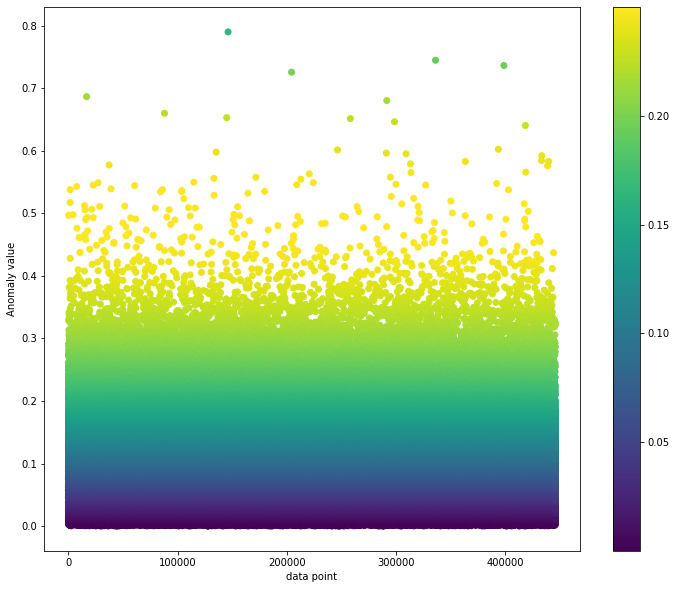

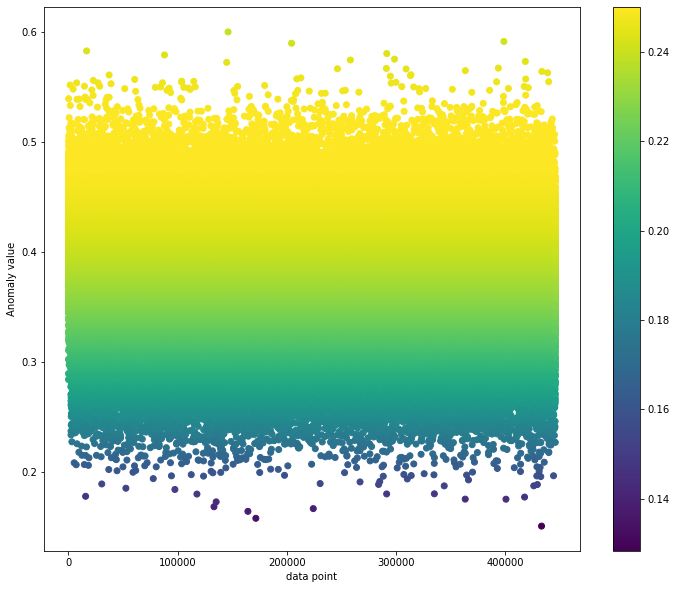

In [45]:

def plot_point_UQ(Xpoint, Ypoint, UQ):
    # display a 2D plot of the digit classes 
    pyplot.figure(figsize=(12, 10))
    pyplot.scatter(Xpoint,Ypoint, c=UQ)
    pyplot.colorbar()
    pyplot.xlabel("data point")
    pyplot.ylabel("Anomaly value") # Anomaly Score  # Anomaly Probability
    pyplot.show()

#x_train = np.expand_dims(x_train, -1).astype("float32") / 255
print(dist)
# plot_point_UQ(mean_AP[dist], test_y, mean_alea[dist] +mean_epis[dist])
# plot_point_UQ(mean_AP['AS'], test_y, mean_AS_alea +mean_AS_epis)
plot_point_UQ(range(0,len(mean_AP[dist])),mean_AP[dist],  mean_alea[dist] +mean_epis[dist])
plot_point_UQ(range(0,len(mean_AP['AS'])),mean_AP['AS'], mean_AS_alea +mean_AS_epis)
#plot_point_UQ(range(0,len(test_y[np.where(test_y==1)])),mean_AP[dist],  mean_alea[dist] +mean_epis[dist])



## plot single total uncertainty

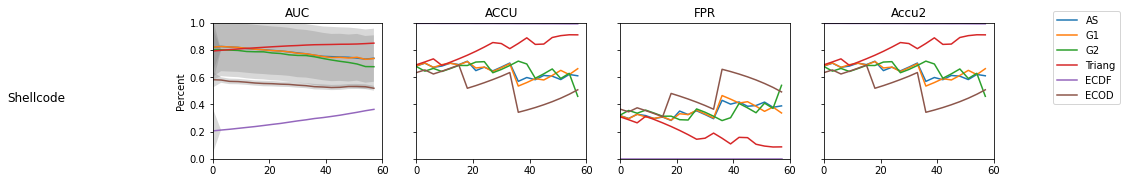

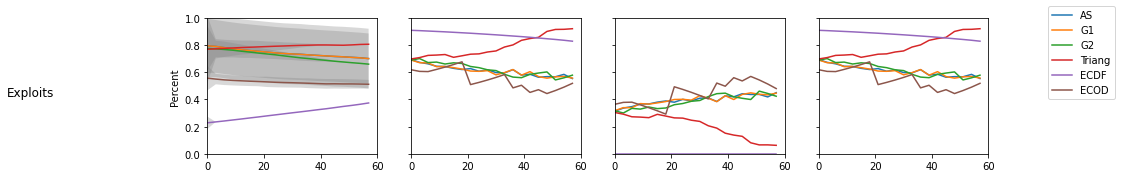

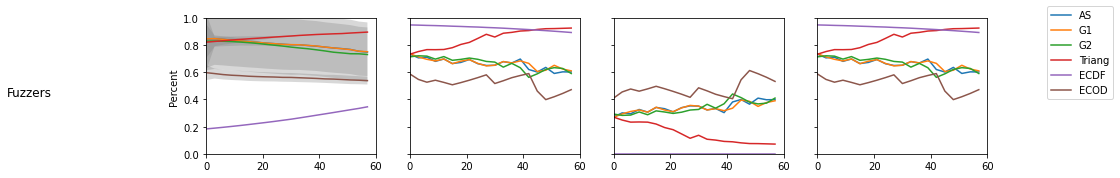

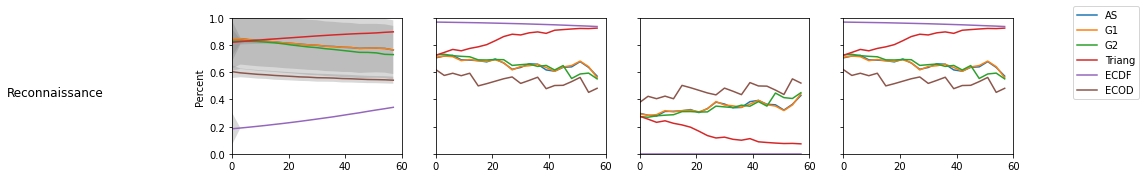

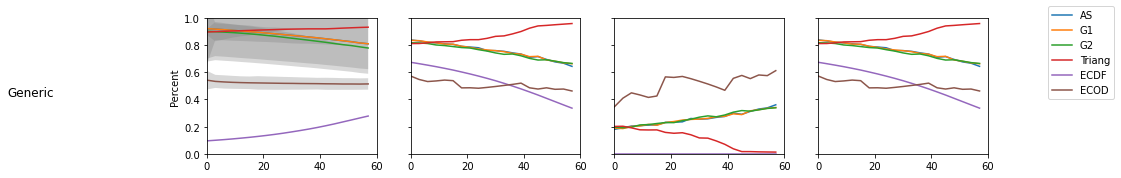

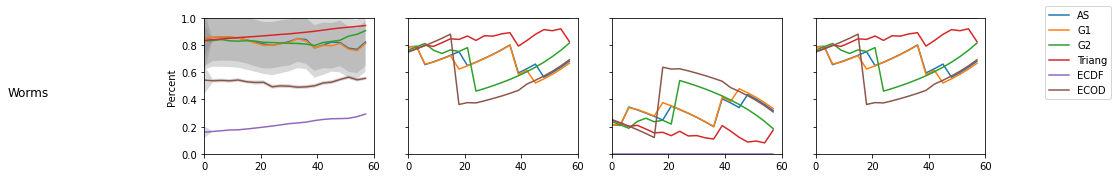

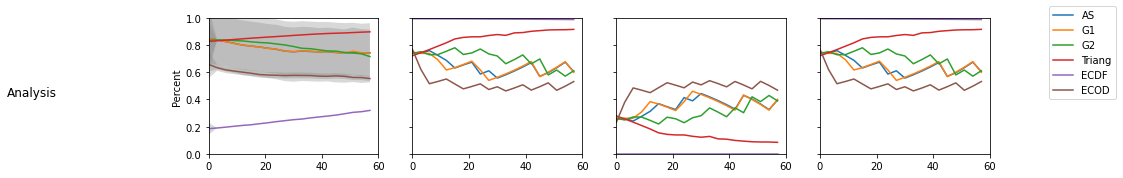

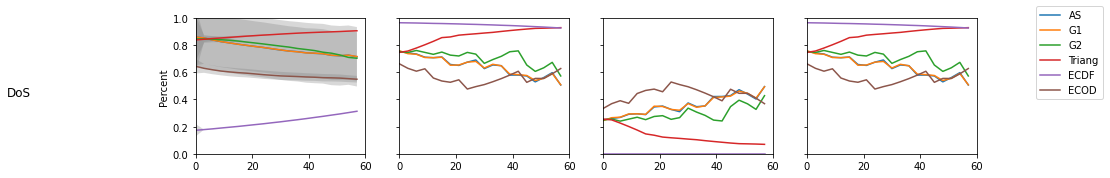

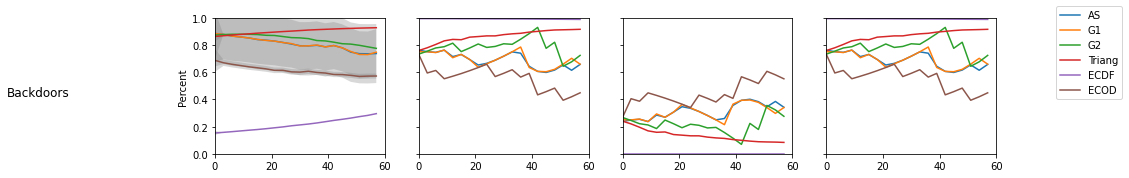

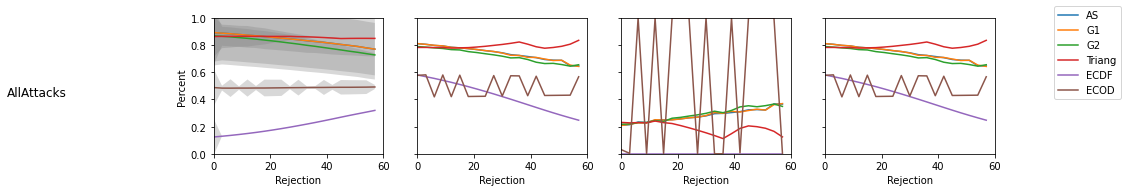

In [19]:
# need run two times for mse and mae
newname=savename+'-mae'
#newname=savename+'-mse'
pd_reader=pd.read_csv('../../venv/MyBayesian/pplots/BDL'+newname+'+allmetrics.csv' )  #,skiprows=251)
#print(pd_reader.head())

''' plot comparision in different phase of each type
the first uncertainty metrics, normally is total uncertainty.'''
total_auc=0 # average of the largest AUC of each types
modelname='BDL'
tw_auc,tw_accu=0,0
model_dict_total={}
model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    best_auc=0
    w_auc=0  #average
    w_accu=0  # average
    i=1
    while i<len(pd_reader):
        flag=False 
    #for i in range(1, len(pd_reader)):#,18*3
        if '+' in pd_reader.iloc[i,0] :
            
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict_total.keys():
                    model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                    
                else: 
                    model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                    
                #fig_title=pd_reader.iloc[i,0]
                try:
                    xx=pd_reader.iloc[i+2,1:].astype(int)
                except:
                    print(i)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)
                ''' 
                if best_auc<  np.max(y_values):
                    best_auc=np.max(y_values)
                if w_auc<float(pd_reader.iloc[i+17,2]):
                    w_auc=float( pd_reader.iloc[i+17,2])
                    # print(f'the better weight_auc {w_auc}is belongs: {attack_types[each]}{legendd}')
                if w_accu<float(pd_reader.iloc[i+17,3]):
                    w_accu=float(pd_reader.iloc[i+17,3])
                    #print(f'the better weight_accu {w_accu}is belongs: {attack_types[each]}{legendd}')
                   # for remove angles
                for ind in range(1,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.6:
                        yyy=y_values[:,ind-1]                        
                        xxx=xx[:,ind-1]
                        '''
                # AUC
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(xx, pd_reader.iloc[i+9,1:].astype(np.float16) ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # macro F1
                #ax4.plot(xx, pd_reader.iloc[i+11,1:].astype(np.float16) ) # , 'tab:red') 
                
                ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+4,0]) 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
                '''
                if legendd=='GaussianCustom':
                    i=i+18*3 
                    flag=True
                elif legendd=='ECODLinear':
                    i=i+18
                    flag=True
                    '''
                i=i+18*3
                flag=True
        if not flag:
            i=i+1   
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    '''    
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)  
    
    pyplot.savefig('plots/'+newname+"+allmetrics.png")
    '''
    pyplot.show()
    

for aproblegend in model_dict_total.keys():
    if aproblegend != 'metricname':
        model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)

#print(f'the AUC of this model is {total_auc}')
save_path = "pplots/"+'allmetrics'+".csv"
#final_AUC={'total_AUC':total_auc, 'weight_AUC:':tw_auc,'weight_Accu:':tw_accu}
#save_data = pd.DataFrame.from_dict([final_AUC])
#save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

save_data=pd.DataFrame(model_dict_total)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

## 3+1

In [ ]:
#savename=''
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BDL'+savename+'+allmetrics.csv' )  #,skiprows=251)   
#print(pd_reader.head())
modelname='BAE'
model_dict_total={}
model_dict_alea={}
model_dict_epis={}
model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    #fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    #fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    i=1
    #for i in range(1,len(pd_reader)):  # ,18*3):
    while i<len(pd_reader):
        flag=False
        if '+' in pd_reader.iloc[i,0] :
            
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict_total.keys():
                    if legendd=='GaussianCustom':
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                        model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                        model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)
                    elif legendd=='ECODLinear':
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                else: 
                    if legendd=='GaussianCustom':
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                        model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                        model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16) 
                    elif legendd=='ECODLinear':
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16) 
               
                if legendd=='GaussianCustom':
                    i=i+18*3 
                    flag=True
                elif legendd=='ECODLinear':
                    i=i+18
                    flag=True
                
        if not flag:
            i=i+1
   
    
model_dict_total["GaussianCustom"]=model_dict_total["GaussianCustom"]/(len(attack_types)-1)
model_dict_alea["GaussianCustom"]=model_dict_alea["GaussianCustom"]/(len(attack_types)-1)
model_dict_epis["GaussianCustom"]=model_dict_epis["GaussianCustom"]/(len(attack_types)-1)
model_dict_total["ECODLinear"]=model_dict_total["ECODLinear"]/(len(attack_types)-1)
#model_dict_alea["ECODLinear"]=model_dict_alea["ECODLinear"]/(len(attack_types)-1)
#model_dict_epis["ECODLinear"]=model_dict_epis["ECODLinear"]/(len(attack_types)-1)

save_path = "pplots/BDL"+savename+'+allmetricsSum'+".csv"

save_data=pd.DataFrame(model_dict_total)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_dict_alea)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_dict_epis)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

# 2.RP

In [ ]:
alluncertainty_dict={}     # record all UQ under multiple distributions on anoamly score.
all_AS_AP_dict={}    # record all anoamly scores and anoamly probabilities in T times repeats.
all_AS_AP_2_dict={}
all_test_y_2_dict={}
#savename="unsw6-vi-vae-diag-bce"
newname=savename+'-rpNorm'
T=M      # the times of prediction, i.e. the number of parameters samples.
distribution_types=['G1','G2', 'Triang','ECDF']       #  'GC','Gamma','Poisson','Uniform','T',,'ECOD'
'''
G1: standard Gaussian, i.e. mean=0,std=1
G2: customized Gaussian using CDF()
GC: customized Gaussian using erf()
'''
#start to timeing
start=time.time()
for root,dirs,files in os.walk(dicnpy):
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
            #if each=='Shellcode.npy':
                print(each)
                cont=np.load(dicnpy+each,allow_pickle=True)
                testdata=np.concatenate([cont,normal_test],axis=0)  
                test_x,test_y=column_split_bina(testdata)
                if type(test_x)==False:
                    print('test_x is False!')
                
                all_test_y_2_dict[each]=test_y
                # scale data
                t = MinMaxScaler()
                t.fit(test_x)
                test_x2 = t.transform(test_x)
                
                mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_AS=0     # the averaging of anomaly scores
 #***********************************************************RP for VAE, BAE last**************************************
                #test_recon =test_recon_mu+test_recon_std*tf.random.stateless_normal(shape=(original_dim,))#0.1 # when x~(mu,std)
                #test_recon_mu, test_recon_std, test_recon=bae_model.predict(test_x2)                
                #test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(BDL_model,test_x2, 3,uqname='Kwon') #  'Kendall') #  repeat times
                for i in range(0,T):
                    # BDL_model_test = BAE_AD(orig_dim=original_dim)
                    # oldsavename=savegroup+str(i)
                    # ## Restore the weights
                    # BDL_model_test.load_weights('./unsw_checkpoints/'+oldsavename)  #, by_name=True)  #when using for transforming
                    # savename=oldsavename

                    outp=BDL_model.predict(test_x2)
                    if len(outp)==3:  # for Tensorflow models
                        test_recon_mu,test_recon_std,test_recon=outp[0],outp[1],outp[2]
                    elif len(outp)==1 or len(outp)>20:
                        test_recon=outp
                        test_recon_mu=np.mean(test_recon)
                        test_recon_std=np.var(test_recon)
                    else:  # for BangXY models
                        test_recon=outp['y_pred']  # 'se','bce'
                        test_recon_mu=np.mean(test_recon)
                        test_recon_std=np.var(test_recon)   
                        
                    #rp_vector=test_recon.log_prob(test_x2)
                    # test 7  option1:RP following Normal
                    rp_vector=RP_normal(test_x2,test_recon_mu, test_recon_std)
                    rp_vector=rp_vector.numpy() 
                    rp_vector = np.nan_to_num(rp_vector)
                    rp_vector[np.where(rp_vector==np.inf)]=1                    
                    rp_vector[np.where( rp_vector==-np.inf)]=0
                    #rp_vector=np.clip(rp_vector,1e-10, np.max(rp_vector))
                    rp_vector=1-rp_vector

                    # test 7.1  option2: RP following Multivariate Gaussian 
                    rp_2_vector= rp_vector # RP_multivariate(test_x2,test_recon_mu, test_recon_std) 
                    #rp_2_vector=RP_normal_outp(test_x2,test_recon)
                    #rp_2_vector=rp_2_vector.flatten()     
                    rp_2_vector = np.nan_to_num(rp_2_vector)
                    rp_vector[np.where(rp_vector==np.inf)]=1                    
                    rp_vector[np.where( rp_vector==-np.inf)]=0
                    #rp_2_vector=np.clip(rp_2_vector,0, np.max(rp_2_vector))
                    rp_2_vector=1-rp_2_vector
                    all_AS_AP_2_dict[each+'_AS_'+str(i)]=rp_2_vector
                    
                    #### simple
                    # 2.MVN  
                    # test_recon=tfp.distributions.MultivariateNormalDiag(test_mu,test_std).sample()   #concerned Diag deviation; but deprecated; same value to log_prob()
                    # 3. MVN Tril
                    # scale=tf.matmul(test_recon_std,test_recon_std,transpose_a=True)  # Multivariate Gaussian full covariance 
                    # test_recon=tfd.MultivariateNormalTriL(test_recon_mu,scale)   .sample()
                    # test_recon =tfp.distributions.Normal(test_recon_mu,test_recon_std).sample()
                    '''
                    # plot roc-aut figure               
                    bestthresh= rocauc(each+'_Prob',test_y,1-rp_vector)
                    print(bestthresh)
                    anomalies=rp_vector<1-bestthresh
                    print(classification_report(test_y, anomalies))                
                    '''  

                    all_AS_AP_dict[each+'_AS_'+str(i)]=rp_vector
                    mean_AS=mean_AS+rp_vector
                
                    # test 2.1------------------------standard Gaussian------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)   ######################
                    #mae_vector_prob=regular_linear(rp_vector) 
                    mae_vector_prob=copy.deepcopy(rp_vector)
                    
                    # 1.the anomaly scores following Gaussian distribution
                    #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
                    #mae_vector_prob=cdf_gaussian_1( mae_vector_prob) 
                    
                    mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
                    #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

                    all_AS_AP_dict[each+'_AP_'+str(i)+'_G1']=mae_vector_prob
                    mean_G1=mean_G1+mae_vector_prob

                     #-------------------Customized Gaussian using CDF-----------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)   ######################
                    #mae_vector_prob=regular_linear(rp_vector) 
                    mae_vector_prob=copy.deepcopy(rp_vector)
                    
                    # 2.the anomaly scores following Gaussian distribution
                    #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
                    #mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
                    mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_G2']=mae_vector_prob 
                    mean_G2=mean_G2+mae_vector_prob
                    
                    '''
                    ##----------------------------Customized Gaussian using erf()-----------------------------------------
                    # test ,not good
                    ##mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)  
                    #mae_vector_prob=copy.deepcopy(rp_vector)

                    # 3.the anomaly scores following Gaussian distribution
                    #mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

                    mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                    #mae_vector_prob=np.absolute(mae_vector_prob)

                    all_AS_AP_dict[each+'_AP_'+str(i)+'_GC']=mae_vector_prob
                    mean_GC=mean_GC+mae_vector_prob
                    
                    
                    # 4.the anomaly scores following Gamma distribution -----------------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    #mae_vector_prob=copy.deepcopy(rp_vector )               
                    #mae_vector_prob=add_gamma(mae_vector_prob)   
                    #mae_vector_prob=cdf_gamma( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_gamma(mae_vector_prob)
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
                    mean_Gamma=mean_Gamma+mae_vector_prob


                     # 5.the anomaly scores following poisson distribution   ------------------------------ 
                    #mae_vector_prob=regular_log(rp_vector)
                    #mae_vector_prob=regular_linear(rp_vector)
                    mae_vector_prob=copy.deepcopy(rp_vector  )              
                    mae_vector_prob=add_poisson(mae_vector_prob)   
                    #mae_vector_prob=cdf_poisson( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_poisson(mae_vector_prob)
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_Poisson']=mae_vector_prob
                    mean_Poisson=mean_Poisson+mae_vector_prob

                     # 6.the anomaly scores following uniform distribution ----------------------------------- 
                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    #mae_vector_prob=copy.deepcopy(rp_vector)                
                    #mae_vector_prob=add_uniform(mae_vector_prob)     
                    #mae_vector_prob=cdf_uniform( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_uniform(mae_vector_prob)
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
                    mean_Uniform=mean_Uniform+mae_vector_prob
                    '''
                     # 7.the anomaly scores following studentst distribution   ----------------------------------    

                    #mae_vector_prob=regular_log(rp_vector)
                    #mae_vector_prob=regular_linear(rp_vector)
                    mae_vector_prob=copy.deepcopy(rp_vector )               
                    #mae_vector_prob=add_triang(mae_vector_prob)     
                    #mae_vector_prob=cdf_triang( mae_vector_prob) 
                    
                    mae_vector_prob=normalization_triang(mae_vector_prob)
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_Triang']=mae_vector_prob
                    mean_Triang=mean_Triang+mae_vector_prob

                    '''
                     # 8.the anomaly scores following studentst distribution   ----------------------------------    

                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    #mae_vector_prob=copy.deepcopy(rp_vector)                
                    #mae_vector_prob=add_t(mae_vector_prob) 
                    #mae_vector_prob=cdf_t( mae_vector_prob) 
                    
                    mae_vector_prob=normalization_t(mae_vector_prob)
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_T']=mae_vector_prob
                    mean_T=mean_T+mae_vector_prob
                    '''
                    # test 9 -----------------------pure CDF-------------------------------------
                    # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
                    #3. alternative: pure cdf()   
                    #mae_vector_prob=stats.norm.cdf(rp_vector)  
                    #-------------------------------ECDF-----------------------------------------
                    # 3.1 ecdf       
                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    mae_vector_prob=normalization_ECDF(mae_vector_prob)
                    #mae_vector_prob=cdf_ECDF( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    all_AS_AP_dict[each+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
                    mean_ECDF=mean_ECDF+mae_vector_prob
                    '''
                    # test 10---------------------ECOD-------------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)       ###################### 
                    #mae_vector_prob=regular_linear(rp_vector)    
                    mae_vector_prob=copy.deepcopy(rp_vector)
                    mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
                    #mae_vector_prob=np.absolute(mae_vector_prob)

                     # scale data
                    t = MinMaxScaler()
                    temp=tf.reshape(mae_vector_prob,[-1,1])
                    t.fit(temp)
                    temp = t.transform(temp)                
                    mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

                    all_AS_AP_dict[each+'_AP_'+str(i)+'_ECOD']=mae_vector_prob
                    mean_ECOD=mean_ECOD+mae_vector_prob
                    '''
                mean_AP={}
                mean_AP['AS']=mean_AS/T
                mean_AP['G1']=mean_G1/T
                mean_AP['G2']=mean_G2/T
                mean_AP['GC']=mean_GC/T
                mean_AP['Gamma']=mean_Gamma/T
                mean_AP['Poisson']=mean_Poisson/T
                mean_AP['Uniform']=mean_Uniform/T
                mean_AP['Triang']=mean_Triang/T
                mean_AP['T']=mean_T/T
                mean_AP['ECDF']=mean_ECDF/T
                mean_AP['ECOD']=mean_ECOD/T
                mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_AS=0     # the averaging of anomaly scores
                              
                mean_alea={}
                mean_epis={}
                for dist in distribution_types:
                    mean_alea[dist]=0
                    mean_epis[dist]=0
                    
                mean_AS_alea=0
                mean_AS_epis=0
                    
                for i in range(0,T):  
                    mean_AS_alea+= all_AS_AP_dict[each+'_AS_'+str(i)]*(1-all_AS_AP_dict[each+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                    #mean_AS_alea+= all_AS_AP_dict[each+'_AS_'+str(i)]-np.mean(all_AS_AP_dict[each+'_AS_'+str(i)])   # for Gaussian    # or (x*-loss) from training
                    mean_AS_epis +=(all_AS_AP_dict[each+'_AS_'+str(i)] - mean_AP['AS'])**2   
                    
                    for dist in distribution_types:
                        if all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                            # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                            mean_alea[dist] += np.mean(all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                            mean_epis[dist] += (np.mean(all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                            #epi=np.absolute(epi)    # sometimes epi<0 ?
                        else:
                            mean_alea[dist] += all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                            mean_epis[dist] +=(all_AS_AP_dict[each+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                            #epi=np.absolute(epi)   
                mean_AS_alea=mean_AS_alea/T
                #mean_AS_alea=np.clip(mean_AS_alea,0, np.max(mean_AS_alea))
                mean_AS_epis=mean_AS_epis/T
                #mean_AS_epis=np.clip(mean_AS_epis,0, np.max(mean_AS_epis))
                alluncertainty_dict[each+'_AS_alea']=mean_AS_alea
                alluncertainty_dict[each+'_AS_epis']=mean_AS_epis
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_alea+mean_AS_epis, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_alea, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_epis, y_true=test_y,plot=False) 
                
                for dist in distribution_types:
                    mean_alea[dist]=mean_alea[dist]/T
                    #mean_alea[dist]=np.clip(mean_alea[dist],0, np.max(mean_alea[dist]))
                    mean_epis[dist]=mean_epis[dist]/T 
                    #mean_epis[dist]=np.clip(mean_epis[dist],0, np.max(mean_epis[dist]))                    
                    alluncertainty_dict[each+'_'+dist+'_alea']=mean_alea[dist] 
                    alluncertainty_dict[each+'_'+dist+'_epis']=mean_epis[dist]
                    
                    #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+each)
                    
                    #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
                    uncer_total=mean_alea[dist] +mean_epis[dist]
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=uncer_total, y_true=test_y,plot=False)  #uncer_total
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=mean_alea[dist], y_true=test_y,plot=False) 
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                unc_total=mean_epis[dist], y_true=test_y,plot=False) 
                
                 #break
end=time.time()                 
runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['test'],'M':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)],'batch':[0],'epoch':[0]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)    


In [31]:
# for Normal distribution reconstruction
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP, alluncertainty_dict,all_AS_AP_dict

In [ ]:
#newname=savename  +'-rpNorm'
metric3UQ(newname)

In [ ]:
''' second time treatment on the prediction data.
'''
newname=savename+'-rpTril'
#start to timeing
start=time.time()
for root,dirs,files in os.walk(dicnpy):
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
            #if each=='Shellcode.npy':
                print(each)
                
                mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_AS=0     # the averaging of anomaly scores
 #***********************************************************RP for VAE, BAE last**************************************
                #test_recon =test_recon_mu+test_recon_std*tf.random.stateless_normal(shape=(original_dim,))#0.1 # when x~(mu,std)
                #test_recon_mu, test_recon_std, test_recon=bae_model.predict(test_x2)                
                #test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(BDL_model,test_x2, 3,uqname='Kwon') #  'Kendall') #  repeat times
                for i in range(0,T):
                    # BDL_model_test = BAE_AD(orig_dim=original_dim)
                    # oldsavename=savegroup+str(i)
                    # ## Restore the weights
                    # BDL_model_test.load_weights('./unsw_checkpoints/'+oldsavename)  #, by_name=True)  #when using for transforming
                    # savename=oldsavename                    
                    rp_vector=[]
                    rp_vector=all_AS_AP_2_dict[each+'_AS_'+str(i)]
                    mean_AS=mean_AS+rp_vector
                
                    # test 2.1------------------------standard Gaussian------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)   ######################
                    #mae_vector_prob=regular_linear(rp_vector) 
                    mae_vector_prob=copy.deepcopy(rp_vector)
                    
                    # 1.the anomaly scores following Gaussian distribution
                    #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
                    #mae_vector_prob=cdf_gaussian_1( mae_vector_prob) 
                    
                    mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
                    #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_G1']=mae_vector_prob
                    mean_G1=mean_G1+mae_vector_prob

                     #-------------------Customized Gaussian using CDF-----------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)   ######################
                    #mae_vector_prob=regular_linear(rp_vector) 
                    mae_vector_prob=copy.deepcopy(rp_vector)
                    
                    # 2.the anomaly scores following Gaussian distribution
                    #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
                    #mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
                    mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
                    #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_G2']=mae_vector_prob 
                    mean_G2=mean_G2+mae_vector_prob
                    
                    '''
                    ##----------------------------Customized Gaussian using erf()-----------------------------------------
                    # test ,not good
                    ##mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)  
                    #mae_vector_prob=copy.deepcopy(rp_vector)

                    # 3.the anomaly scores following Gaussian distribution
                    #mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

                    mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
                    #mae_vector_prob=np.absolute(mae_vector_prob)

                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_GC']=mae_vector_prob
                    mean_GC=mean_GC+mae_vector_prob
                    
                    
                    # 4.the anomaly scores following Gamma distribution -----------------------------------------------

                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    #mae_vector_prob=copy.deepcopy(rp_vector )               
                    #mae_vector_prob=add_gamma(mae_vector_prob)   
                    #mae_vector_prob=cdf_gamma( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_gamma(mae_vector_prob)
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
                    mean_Gamma=mean_Gamma+mae_vector_prob


                     # 5.the anomaly scores following poisson distribution   ------------------------------ 
                    #mae_vector_prob=regular_log(rp_vector)
                    #mae_vector_prob=regular_linear(rp_vector)
                    mae_vector_prob=copy.deepcopy(rp_vector  )              
                    mae_vector_prob=add_poisson(mae_vector_prob)   
                    #mae_vector_prob=cdf_poisson( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_poisson(mae_vector_prob)
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_Poisson']=mae_vector_prob
                    mean_Poisson=mean_Poisson+mae_vector_prob


                     # 6.the anomaly scores following uniform distribution -----------------------------------    

                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    #mae_vector_prob=copy.deepcopy(rp_vector)                
                    #mae_vector_prob=add_uniform(mae_vector_prob)     
                    #mae_vector_prob=cdf_uniform( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_uniform(mae_vector_prob)
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
                    mean_Uniform=mean_Uniform+mae_vector_prob
                    '''
                     # 7.the anomaly scores following Triang distribution   ----------------------------------    

                    #mae_vector_prob=regular_log(rp_vector)
                    #mae_vector_prob=regular_linear(rp_vector)
                    mae_vector_prob=copy.deepcopy(rp_vector )               
                    #mae_vector_prob=add_triang(mae_vector_prob)     
                    #mae_vector_prob=cdf_triang( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_triang(mae_vector_prob)
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_Triang']=mae_vector_prob
                    mean_Triang=mean_Triang+mae_vector_prob

                    '''
                     # 8.the anomaly scores following studentst distribution   ----------------------------------    

                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    #mae_vector_prob=copy.deepcopy(rp_vector)                
                    #mae_vector_prob=add_t(mae_vector_prob) 
                    #mae_vector_prob=cdf_t( mae_vector_prob) 
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                    mae_vector_prob=normalization_t(mae_vector_prob)
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_T']=mae_vector_prob
                    mean_T=mean_T+mae_vector_prob
                    '''
                    # test 9 -----------------------pure CDF-------------------------------------
                    # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
                    #3. alternative: pure cdf()   
                    #mae_vector_prob=stats.norm.cdf(rp_vector)  
                    #-------------------------------ECDF-----------------------------------------
                    # 3.1 ecdf       
                    #mae_vector_prob=regular_log(rp_vector)
                    mae_vector_prob=regular_linear(rp_vector)
                    mae_vector_prob=normalization_ECDF(mae_vector_prob)
                    #mae_vector_prob=cdf_ECDF( mae_vector_prob) 
                    
                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
                    mean_ECDF=mean_ECDF+mae_vector_prob
                    '''
                    # test 10---------------------ECOD-------------------------------------------
                    #mae_vector_prob=regular_log(rp_vector)       ###################### 
                    #mae_vector_prob=regular_linear(rp_vector)    
                    mae_vector_prob=copy.deepcopy(rp_vector)
                    mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
                    #mae_vector_prob=np.absolute(mae_vector_prob)
                    
                    mae_vector_prob = np.nan_to_num(mae_vector_prob)
                    mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
                    mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
                    #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
                    
                     # scale data
                    t = MinMaxScaler()
                    temp=tf.reshape(mae_vector_prob,[-1,1])
                    t.fit(temp)
                    temp = t.transform(temp)                
                    mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

                    all_AS_AP_2_dict[each+'_AP_'+str(i)+'_ECOD']=mae_vector_prob
                    mean_ECOD=mean_ECOD+mae_vector_prob
                    '''
                mean_AP={}
                mean_AP['AS']=mean_AS/T
                mean_AP['G1']=mean_G1/T
                mean_AP['G2']=mean_G2/T
                mean_AP['GC']=mean_GC/T
                mean_AP['Gamma']=mean_Gamma/T
                mean_AP['Poisson']=mean_Poisson/T
                mean_AP['Uniform']=mean_Uniform/T
                mean_AP['Triang']=mean_Triang/T
                mean_AP['T']=mean_T/T
                mean_AP['ECDF']=mean_ECDF/T
                mean_AP['ECOD']=mean_ECOD/T
                mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_AS=0     # the averaging of anomaly scores
                              
                mean_alea={}
                mean_epis={}
                for dist in distribution_types:
                    mean_alea[dist]=0
                    mean_epis[dist]=0
                    
                mean_AS_alea=0
                mean_AS_epis=0
                    
                for i in range(0,T):  
                    mean_AS_alea+= all_AS_AP_2_dict[each+'_AS_'+str(i)]*(1-all_AS_AP_2_dict[each+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                    #mean_AS_alea+= all_AS_AP_2_dict[each+'_AS_'+str(i)]-np.mean(all_AS_AP_2_dict[each+'_AS_'+str(i)])   # for Gaussian    # or (x*-loss) from training
                    mean_AS_epis +=(all_AS_AP_2_dict[each+'_AS_'+str(i)] - mean_AP['AS'])**2   
                    
                    for dist in distribution_types:
                        if all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                            # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                            mean_alea[dist] += np.mean(all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                            mean_epis[dist] += (np.mean(all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                            #epi=np.absolute(epi)    # sometimes epi<0 ?
                        else:
                            mean_alea[dist] += all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                            mean_epis[dist] +=(all_AS_AP_2_dict[each+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                            #epi=np.absolute(epi)   
                mean_AS_alea=mean_AS_alea/T
                #mean_AS_alea=np.clip(mean_AS_alea,0, np.max(mean_AS_alea))  
                mean_AS_epis=mean_AS_epis/T
                #mean_AS_epis=np.clip(mean_AS_epis,0, np.max(mean_AS_epis))  
                alluncertainty_dict[each+'_AS_alea']=mean_AS_alea
                alluncertainty_dict[each+'_AS_epis']=mean_AS_epis
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_alea+mean_AS_epis, y_true=all_test_y_2_dict[each],plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_alea, y_true=all_test_y_2_dict[each],plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_epis, y_true=all_test_y_2_dict[each],plot=False) 
                
                for dist in distribution_types:
                    mean_alea[dist]=mean_alea[dist]/T
                    #mean_alea[dist]=np.clip(mean_alea[dist],0, np.max(mean_alea[dist]))  
                    mean_epis[dist]=mean_epis[dist]/T 
                    #mean_epis[dist]=np.clip(mean_epis[dist],0, np.max(mean_epis[dist]))                      
                    alluncertainty_dict[each+'_'+dist+'_alea']=mean_alea[dist] 
                    alluncertainty_dict[each+'_'+dist+'_epis']=mean_epis[dist]
                    
                    #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+each)
                    
                    #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
                    uncer_total=mean_alea[dist] +mean_epis[dist]
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=uncer_total, y_true=all_test_y_2_dict[each],plot=False)  #uncer_total
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=mean_alea[dist], y_true=all_test_y_2_dict[each],plot=False) 
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                unc_total=mean_epis[dist], y_true=all_test_y_2_dict[each],plot=False) 
                
                 #break
end=time.time()                 
runTime=pd.DataFrame({'modelname':['BDL'+newname],'T':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)    

del result_dict, mean_AP, uncer_total,mean_alea,mean_epis,mean_AS_alea,mean_AS_epis

In [ ]:
# for MVN Tril reconstruction
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_2_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP,alluncertainty_dict,all_AS_AP_2_dict, all_test_y_2_dict

In [ ]:

#newname=savename  +'-rpTril'
metric3UQ(newname)

## plot total

In [ ]:
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE+allmetrics.csv' )  #,skiprows=251)

# plot comparision in different phase of each type
total_auc=0 # average of the largest AUC of each types
modelname='BAE-MCD'
tw_auc,tw_accu=0,0
model_dict={}
model_dict["metricname"]=pd_reader.iloc[17,1:11]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    best_auc=0
    w_auc=0  #average
    w_accu=0  # average
    for i in range(0,len(pd_reader)):
        if '+' in pd_reader.iloc[i,0] :
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict.keys():
                    model_dict[legendd]=(model_dict[legendd]+pd_reader.iloc[i+17,1:11].astype(np.float16))/2.0
                else: 
                    model_dict[legendd]=pd_reader.iloc[i+17,1:11].astype(np.float16)     
                    
                #fig_title=pd_reader.iloc[i,0]
                xx=pd_reader.iloc[i+2,1:].astype(int)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)
                
                if best_auc<  np.max(y_values):
                    best_auc=np.max(y_values)
                if w_auc<float(pd_reader.iloc[i+17,2]):
                    w_auc=float( pd_reader.iloc[i+17,2])
                    # print(f'the better weight_auc {w_auc}is belongs: {attack_types[each]}{legendd}')
                if w_accu<float(pd_reader.iloc[i+17,3]):
                    w_accu=float(pd_reader.iloc[i+17,3])
                    #print(f'the better weight_accu {w_accu}is belongs: {attack_types[each]}{legendd}')
                '''    # for remove angles
                for ind in range(1,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.6:
                        yyy=y_values[:,ind-1]                        
                        xxx=xx[:,ind-1]
                        '''
                # AUC
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-y_uncer,y_values+y_uncer,alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(xx, pd_reader.iloc[i+9,1:].astype(np.float16) ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # Macro F1
                ax4.plot(xx, pd_reader.iloc[i+11,1:].astype(np.float16) ) # , 'tab:red')               
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+10,0]) 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
                i=i+18  
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    '''
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)    
    pyplot.savefig('plots/'+modelname+'+'+nowtime+'+'+"allmetrics.png")
    '''
    pyplot.show()
    
         
print(f'the AUC of this model is {total_auc}')
save_path = "pplots/"+'allmetrics'+".csv"
#final_AUC={'total_AUC':total_auc, 'weight_AUC:':tw_auc,'weight_Accu:':tw_accu}
#save_data = pd.DataFrame.from_dict([final_AUC])
#save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

save_data=pd.DataFrame(model_dict)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [ ]:
# for part sum under conditions
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE'+savename+'+allmetrics.csv' )  #,skiprows=251)
#print(pd_reader.head())

# plot comparision in different phase of each type
#total_auc=0 # average of the largest AUC of each types
#modelname='BAE MCdropout'
#tw_auc,tw_accu=0,0
#avg_auc,avg_accu,avg_macro=0,0,0
model_part={}
model_part['label']=["avgAUC","avgAccu","avgMacro"]
model_dict_total={}
model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    #best_auc=0
    #w_auc=0  #average
    #w_accu=0  # average
    i=1
    while i <len(pd_reader):
        flag=False
    #for i in range(1,len(pd_reader)):#,18*3
        if '+' in pd_reader.iloc[i,0] :
            
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]                   
                    
                #fig_title=pd_reader.iloc[i,0]
                try:
                    xx=pd_reader.iloc[i+2,1:].astype(int)
                except:
                    print(i)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # AUC
                y_accu=pd_reader.iloc[i+9,1:].astype(np.float16) 
                y_macro=pd_reader.iloc[i+11,1:].astype(np.float16)
                ''' 
                if best_auc<  np.max(y_values):
                    best_auc=np.max(y_values)
                if w_auc<float(pd_reader.iloc[i+17,2]):
                    w_auc=float( pd_reader.iloc[i+17,2])
                    # print(f'the better weight_auc {w_auc}is belongs: {attack_types[each]}{legendd}')
                if w_accu<float(pd_reader.iloc[i+17,3]):
                    w_accu=float(pd_reader.iloc[i+17,3])
                    #print(f'the better weight_accu {w_accu}is belongs: {attack_types[each]}{legendd}')
                    '''
                y_uncer=np.absolute(y_uncer)
                party_auc=y_values
                party_accu=y_accu
                party_macro=y_macro
                partx_auc, partx_accu, partx_macro=xx,xx,xx
                partuncer_auc, partuncer_accu, partuncer_macro=y_uncer,y_uncer, y_uncer
                   # for remove angles
                for ind in range(2,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.5:
                        party_auc=y_values[:(ind-1)]                        
                        partx_auc=xx[:(ind-1)]
                        partuncer_auc=y_uncer[:(ind-1)]
                        break
                for ind in range(2,len(y_accu)):
                    if np.abs((y_accu[ind-1]-y_accu[ind]))>0.5:
                        party_accu=y_accu[:(ind-1)]                        
                        partx_accu=xx[:(ind-1)]
                        partuncer_accu=y_uncer[:(ind-1)]
                        break
                for ind in range(2,len(y_macro)):
                    if np.abs((y_macro[ind-1]-y_macro[ind]))>0.5:
                        party_macro=y_macro[:(ind-1)]                        
                        partx_macro=xx[:(ind-1)]
                        partuncer_macro=y_uncer[:(ind-1)]
                        break
                        
                # AUC
                ax1.plot(partx_auc,party_auc,label=legendd)                
                ax1.fill_between(partx_auc,party_auc-partuncer_auc, party_auc+partuncer_auc,alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(partx_accu,party_accu)
                ax2.fill_between(partx_accu, party_accu-partuncer_accu, party_accu+partuncer_accu, alpha=0.3, facecolor='grey' ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # Macro F1
                ax4.plot(partx_macro,party_macro)
                #ax4.fill_between(partx_macro, party_macro-partuncer_macro, party_macro+partuncer_macro, alpha=0.3,facecolor='grey' ) # , 'tab:red') 
                
                #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+10,0]) 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
                
                if legendd in model_dict_total.keys():
                    model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)     
                    
                    model_part[legendd+"part"]=np.average([model_part[legendd+"part"], [np.mean(party_auc),np.mean(party_accu),np.mean(party_macro)]],axis=0)
                    #print(model_part["part"])
                else: 
                    model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16) 
                    model_part[legendd+"part"]=[np.mean(party_auc),np.mean(party_accu),np.mean(party_macro)]
                
                flag=True
                i=i+18*3
        if not flag:
            i=i+1
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    '''    
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)  
    
    pyplot.savefig('plots/'+savename+"+allmetrics.png")
    '''
    pyplot.show()
    
for aproblegend in model_dict_total.keys():
    if aproblegend != 'metricname':
        model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)

#model_dict_total['GaussianCustom']=model_dict_total['GaussianCustom']/(len(attack_types)-1)
#model_dict_total['ECODLinear']=model_dict_total['ECODLinear']/(len(attack_types)-1)         
#print(f'the AUC of this model is {total_auc}')

save_path = "plots/BAE"+savename+'+allmetricsPartSum'+".csv"
#final_AUC={'total_AUC':total_auc, 'weight_AUC:':tw_auc,'weight_Accu:':tw_accu}
#save_data = pd.DataFrame.from_dict([final_AUC])
#save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

save_data=pd.DataFrame(model_dict_total)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_part)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [ ]:
print(3)

# plot models

In [ ]:
# plot comparision in different model of each type
fig, axes= pyplot.subplots(2, 5,figsize=(18,7),sharex=True,sharey=True) 
#fig.suptitle('Comparisons of Models' ) 
diccsv='csvsUNSW/'
for indtype in range(1,len( attack_types)): 
    axes[(indtype-1)//5,(indtype-1)%5].set_title(attack_types[indtype] )  #
    
    for root,dirs,files in os.walk(diccsv):
        for each in files:
            if each.endswith('.csv') and each.split('-')[-1]!='checkpoint.csv' :       
                thislabel='??'
                if 'vi' in each or 'VI' in each:
                    thislabel=str(each) # 'BVAE-BBB'
                elif 'drop' in each or 'Dropout' in each:
                    thislabel='BVAE-MCD'
                    
                pd_reader=pd.read_csv(diccsv+each)
                init=0
                # #if thislabel=='BAE-VI':
                # if each=='BAE+allmetrics-unsw-vi-vae-(1)-forECOD.csv':  # for ECOD
                #     init=1441
                probname='Triang'  #'GaussianCustom' # 'ECODLinear'  #   
                # if each=='BAEunsw-3-drop-vae-bce+allmetrics-forG1.csv':
                #     probname='Gaussian1'
                for i in range(init,len(pd_reader)): # show the first group results in csv
                  
                    if '+' in pd_reader.iloc[i,0]:
                        if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[indtype] and pd_reader.iloc[i,0].split('+')[0]==probname:  # 'Gaussian1': #'ECODLinear': #'GaussianCustom': #
                            
                            xx=pd_reader.iloc[i+2,1:].astype(int)
                            y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                            #plot_title=pd_reader.iloc[i+2,0]            
                            #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # AUC

                            #y_values=pd_reader.iloc[i+5,1:].astype(np.float16)  # GSS

                            y_values=pd_reader.iloc[i+9,1:].astype(np.float16)  # Accu
                            
                            axes[(indtype-1)//5,(indtype-1)%5].plot(xx,y_values,label=thislabel)
                            #ax1.fill_between(xx,y_values-y_uncer,y_values+y_uncer,alpha=0.3,facecolor='grey')
                            #ax1.set(ylabel='Percent')
                            if indtype==1 or indtype==6:
                                axes[(indtype-1)//5,(indtype-1)%5].set(ylabel='Percent')
                            if indtype>5:
                                axes[(indtype-1)//5,(indtype-1)%5].set(xlabel='Rejection Rate')
                        
                            break
                            
                            #i=i+18  
handles, labels = axes[0,2].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1,0.5))

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(0,50)
    ax.set_ylim(0,1)

nowtime=datetime.datetime.now()
nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)
pyplot.savefig('csvsUNSW/'+nowtime+'+'+"allmodels.png")
pyplot.show()

In [ ]:
# all attack types as one anomaly type to classify
for root,dirs,files in os.walk(dicnpy):
    testdata=[]
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
                cont=np.load(dicnpy+each,allow_pickle=True)
                
                if len(testdata)>0:
                    testdata=np.concatenate([cont,testdata],axis=0)                     
                else:
                    testdata=cont
    print(testdata.shape)                
    np.save(dicnpy+'AllAttacks.npy',testdata)
    
    '''
    testdata=np.concatenate([testdata,normal_test],axis=0)                 
    test_x,test_y=column_split_bina(testdata)
    if type(test_x)==False:
        print('test_x is False!')

    # scale data
    t = MinMaxScaler()
    t.fit(test_x)
    test_x2 = t.transform(test_x)
    '''

In [37]:
cont=np.load(dicnpy+'AllAttacks.npy',allow_pickle=True)
print(cont.shape)

(321283, 49)


In [38]:
threshold_99 = np.percentile(list_alea, 99.)
threshold_995 = np.percentile(list_alea, 99.5)
threshold_999 = np.percentile(list_alea, 99.9)
threshold_9995 = np.percentile(list_alea, 99.95)
print(threshold_99, threshold_995, threshold_999, threshold_9995)
# alea_index = (list_alea > threshold)

(445264,)
(890528,)


In [ ]:
print('conditional expectation of epistemic')
print(
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.05) and (list_alea[i] < 0.1)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.1) and (list_alea[i] < 0.15)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.15) and (list_alea[i] < 0.2)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.2) and (list_alea[i] < 0.25)])
    )